# Tanzania Water Pump Classifier

The Tanzanian government has worked in conjunction with for-profit and non-profit organizations to build water pumps across Tanzania to provide its denizens with potable water. These pumps need maintenance to continue to operate. It is expensive, time-consuming, and inefficient to send repair teams, and tools and parts, only when the government receives reports of a faulty pump. The purpose of this project is to create a machine learning algorithm that can predict which pumps need repair or replacement to save the time and money of the Tanzanian government and its cooperative organizations.

This data was from a private Kaggle competition held by BloomTech for its DS36 Data Science cohort; its data mirrors that of the community Kaggle competition.

This documentation presents the project narrative in a CRISP-DM process style.

## Import Libraries

All libraries used throughout the notebook will be initialized here.

In [212]:
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from category_encoders import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

from sklearn.metrics import roc_curve, auc, fbeta_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.multiclass import OneVsRestClassifier

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

## Business Understanding

We want to create a machine learning algorithm that can predict which pumps are non-functional. Let's expand on this goal by further developing our understanding of the stakeholder's needs.

### Goal

The Tanzanian government wants to keep the pumps in working order to provide a reliable source of water for its population.

They have "hired" us to build a model that can turn accessible water pump data into three classes of predictions:

1. Functional (the pump is working)
2. Functional needs repair (the pump needs repair)
3. Non functional (the pump needs replacement)

With the predictions, the Tanzanian government will send the necessary tools and teams to the pumps needing repair, and replacement teams to the broken pumps.

### Additional Factors and Considerations

We should be prepared for the inevitability that our model is unlikely predict with perfect accuracy.

An imperfect classification model is subject to Type I and Type II errors. In the case of water pump classification:

- Type I, False Positive: The model predicts that the pump needs repair or replacement when it is in working condition
- Type II, False Negative: The model predicts that the pump is in working condition when it needs repair or replacement

Both types of errors should be avoided, but a Type II error is much more pressing. The worst case scenario in a Type II error would be when the model predicts a pump to be in working condition when it is broken and needs replacement. We're dealing with water, which is necessary to live. A Type I error would result in a waste of resources (sending repair teams and tools to a working pump), but a Type II error may result in a loss of lives!

We could tune our model to eliminate Type II errors, but this would result in more Type I errors; more pumps that are functional would be marked as needing repair or replacement, which would be an unnecessary drain on repair resources.

If we were able to meet with the stakeholder (the Tanzanian government) we would want to clarify how we should prioritize the reduction of these errors.

We will assume that the stakeholder prefers to begin with a model that is as accurate as possible, and make adjustments to account for these errors when we have an MVP (minimum viable product).

We should also assume that the stakeholder will want some understanding of why the model makes the predictions that it does. We will need to be able to explain which features we choose to include in our model, as well as how those features impact the model.

### Accuracy Metric

For the MVP, we will focus on building a model that is as accurate as possible.

There are several metrics we can use, which have their own benefits and drawbacks:

1. Basic accuracy metric
    - Pros: simple
    - Cons: does not account for sensitivity and specificity (measures impact of Type I and Type II errors)
2. Weighted F1 Score
    - Pros: accounts for sensitivity and specificity
    - Cons: does not directly account for poor scores in one classification (averages all classification scores)
3. Multiclass ROC AUC
    - Pros: accounts for sensitivity and specificity; accounts for poor scores in one classification; easiest to visualize; can average scores for one final metric
    - Cons: introduces subjective assessment of success (multiple measures are weighed, assessor must rank measure importance)

In accordance with the idea that the stakeholder may want to make adjustments to the model to account for errors, multiclass ROC AUC is the best choice. We will implement a 'One vs Rest' style of multiclass ROC AUC, which will give us a total of three graphs, with each graph comparing one feature to the other two. Changes to sensitivity and specificity for each class will be most visible while using this metric. In addition, if we wanted a single measure of accuracy, we retain the option to consolidate the scores for each graph into a simple or weighted average.

### Project Plan

Let's outline a plan for how we will approach this project.

1. Data Understanding
    - *Identify data surface qualities*: What is our data format? How many records do we have to train our model?
    - *Verify data quality*: How dirty is the data? Are there any non-existent values? Incorrect values or types?
    - *Understand features*: What kinds of data are available?
    - *Explore data*: What relationships are present in the data? How do we visualize them?
2. Data Preparation
    - *Select / exclude data*: What features and records will we keep or remove? Why?
    - *Clean data*: What values do we need to add, remove, or alter from when we verified data quality?
    - *Format data*: Are the datatypes accurate? Can they be changed? Which are the most useful to our model?
    - *Feature engineering*: Can we introduce better features, or consolidate the features we have to reduce dimensionality?
3. Modeling
    - *Select modeling techniques*: What models will we try?
    - *Determine test design*: How will we test our model?
    - *Build model*: How do we construct our model?
    - *Tune model*: How do we change our model to be more accurate?
    - *Assess model*: What are the results of our tests?
4. Evaluation
    - *Evaluate model result*: Does our model meet the stakeholder's requirements?
    - *Review process*: Did we miss anything? What else should be added?
    - *Determine next steps*: Should we deploy the model, or iterate further?
5. Deployment
    - We expect the stakeholder will want to make this model available for use beyond our project. We will need to create a way for users to provide data to our model, and retrieve its predictions.

The plan is not intended to be strictly sequential - rather, it is intended to be flexible to allow us to return to previous sections to re-evaluate our approach when new information arises or project circumstances change.

## Data Understanding

Before we can manipulate our data or build a model from it, we must understand it.

### Load Data

Let's load our data from the CSV files.

In [107]:
# load data into dataframe
df = pd.merge(
    pd.read_csv('train_labels.csv').set_index('id'),
    pd.read_csv('train_features.csv').set_index('id'),
    left_index=True,
    right_index=True
)

### Split Data

The Kaggle competition originally created for this project had its own private dataset. Since we do not have access to this dataset, we will need to create a testing set from the available data. 

**Why are we splitting our data here, rather than waiting until we need to start testing our model?**

When our stakeholder wants to deploy our model, we won't have the ability to manually alter the data that is inputted into the model. We can't assume that further data provided by the stakeholder/users will be in the format we created during training; we need to expect that the data entering the deployed model will be in the same format and structure as it was provided - possibly dirtied with inaccurate or nonexistent values, and containing features we might remove in the cleaning process. Splitting the data here will force us to consider how we will transform the inputted dirty data into the format the model was trained on because any tidying or feature engineering we perform on the training data before model training will also need to be performed on inputted data. We will need to write a function that accounts for any alterations made to the training data so that when inputted data is passed through that function, the model will recognize the data's format and return a prediction instead of a code error.

We will need to know how many observations we have before splitting, so both our training and testing sets have a healthy amount of data.

In [108]:
print(f"Our dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

Our dataset has 47520 rows and 40 columns.


We should also see what percentage of our dataset each class composes. If the classes are uneven, we will need to perform a stratified split of our data to ensure that our testing dataset has a congruent proportion of each class.

In [109]:
print("The proportion of values in each class is: ")
print(df.status_group.value_counts(normalize=True).to_string())

The proportion of values in each class is: 
functional                 0.542971
non functional             0.384091
functional needs repair    0.072938


Our classes are imbalanced, especially for 'functional needs repair.' Given that this class comprises only 7% of the data, we will need to be careful about how to split our data. We want as many records of this class in our training set as possible so we can create an accurate model, but we want enough records of this class in our testing set to provide meaningful feedback.

Given our near 50,000 records, we should aim to have at least 500 records for the 'functional needs repair' class in our training set. With 500 records, each record in this class will account for 0.2% of the class' prediction accuracy.

To find our optimal split percentage:

$$ 47520 * split_{pct} * 0.0729 = 500 $$
$$ split_{pct} = \frac{500}{47520 * 0.0729} $$
$$ split_{pct} = 0.144 $$

Let's make our testing set an even 15% of our total data.

In [110]:
# split training and testing sets
testing_set = df.groupby('status_group', group_keys=False).apply(lambda x: x.sample(frac=0.15))
training_set = df.drop(testing_set.index, axis=0)
testing_set.reset_index(drop=True, inplace=True)
training_set.reset_index(drop=True, inplace=True)

# validate split
print(f"Our training set has {training_set.shape[0]} rows and our testing set has {testing_set.shape[0]} rows.")
print()
print("The proportion of classes in our training set is: ")
print(training_set.status_group.value_counts(normalize=True).to_string())
print()
print("The proportion of classes in our testing set is: ")
print(testing_set.status_group.value_counts(normalize=True).to_string())
print()
print("The number of 'functional needs repair' records in our testing set is: ")
print(testing_set.status_group.value_counts(ascending=True)[0])


Our training set has 40392 rows and our testing set has 7128 rows.

The proportion of classes in our training set is: 
functional                 0.542979
non functional             0.384086
functional needs repair    0.072935

The proportion of classes in our testing set is: 
functional                 0.542929
non functional             0.384119
functional needs repair    0.072952

The number of 'functional needs repair' records in our testing set is: 
520


We have separated a testing set to test the accuracy of our model. Now let's start looking at the data in our training set.

### Data Source

We've recieved our data in a CSV format from Kaggle, but we should still ask the question, *where does our data come from?*

From the Kaggle competition description:
```
The data comes from the Taarifa waterpoints dashboard, which aggregates data from the Tanzania Ministry of Water. In their own words:

Taarifa is an open-source platform for the crowd-sourced reporting and triaging of infrastructure-related issues. Think of it as a bug tracker for the real world which helps to engage citizens with their local government.
```

So the data is crowd-sourced, perhaps by the citizens using the pumps, or by volunteers. Either way, there are some questions which remain unanswered by the description:
- *Who inputs the data into the dashboard?* Is it the people who use the pumps, volunteers, etc?
- *Are datatypes altered between entry and dashboarding?* Has the data changed in the pipeline between user entries and the CSV we received? Is there a potential for information to be lost in this process?
- *Who verifies the accuracy of the data?* Does the Ministry of Water verify, or does it rely on crowd-sourcing to correct errors?
- *What data is updated, and what data is static?* What data is inputted by dashboard users, and what data remains unaltered since the pump's creation?

In leiu of answers to these questions, we will need to make our best educated guesses about the data we're working with.

### Identify Data Surface Qualities

We should develop a surface-level understanding of the data we're working with before diving deeper.

We've already split our data into training and testing sets, and from that, we know that we have 40392 records to train our model, and we're working with 39 features (40, less the dependent variable 'status group'). Let's take another look at the breakdown of classes in the records, and this time, we'll also include the record counts for each class.

In [111]:
print("The proportion of classes in our training set is: ")
print(training_set.status_group.value_counts(normalize=True).to_string())
print()
print("The record counts of classes in our training set is: ")
print(training_set.status_group.value_counts().to_string())

The proportion of classes in our training set is: 
functional                 0.542979
non functional             0.384086
functional needs repair    0.072935

The record counts of classes in our training set is: 
functional                 21932
non functional             15514
functional needs repair     2946


Let's also take a look at the datatypes, and the number of features with each datatype.

In [112]:
print("The counts for each datatype are: ")
print(training_set.dtypes.value_counts().to_string())

The counts for each datatype are: 
object     31
int64       6
float64     3


The 'object' datatype can take multiple forms, the most common being string data. However, just because the datatype is 'object' does not mean that all of the data in the column is string data. It is possible for an 'object' datatype to contain multiple datatypes. Our data is likely dirty and needs to be cleaned.

### Verify Data Quality

Given that we know our data might be dirty, this is a good time to see how many null (nonexistent) values there are in the data.

In [113]:
print(f"There is a total of {training_set.isnull().sum().sum()} null values in the dataset.")

There is a total of 31357 null values in the dataset.


In [114]:
print("The counts of null values by feature are: ")
print(training_set.isnull().sum().to_string())

The counts of null values by feature are: 
status_group                 0
amount_tsh                   0
date_recorded                0
funder                    2462
gps_height                   0
installer                 2475
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 254
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            2289
recorded_by                  0
scheme_management         2677
scheme_name              19115
permit                    2085
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type               

We have plenty of null values in our data, the most egregious omission being in the 'scheme_name' feature. We will need to determine the importance of this column, as we will likely drop it in the cleaning process because there are so many values missing.

It is important to note that these are only the *explicit* null values, or values explicitly left blank. We will also need to be vigilant in finding *implicit* null values - values which appear as valid in our dataset, but are intended as nulls (such as an 'x' in a field where a string name should be). To identify these possible implicit nulls, we will need to better understand the features we're working with so we can determine which values are valid.

### Understand Features

We have 39 features in our dataset. Let's see what forms they take, and do the research necessary to understand them. This will enable us to achieve better results in the remaining analysis, cleaning, and modeling.

We are trying to identify features with the following attributes:
- Explainable to the stakeholder (we understand the purpose of the feature)
- Low cardinality (features with a lot of unique values are less likely to identify meaningful separations in the target class)
- Low skew (features with heavily skewed distributions are less likely to indentify meaningful separations in the target class)

Features with these attributes will contribute the most to our model's accuracy, and be the easiest to explain when providing the reasoning for our model's choices.

#### Feature Descriptions

The Kaggle competition page provided a list of the features and a brief description for each. This is stored in 'feature_descriptions.json'. For readability, let's construct a dataframe with the feature name, datatype, and description for each feature.

In [115]:
# retrieve names and descriptions from file
with open('feature_descriptions.json', 'r') as read_content:
    feature_descriptions = json.load(read_content)

# prepare name, datatype, and description data
index = pd.Series(feature_descriptions.keys(), name='Feature_Name')
data = zip(
    training_set.dtypes.values[1:],
    feature_descriptions.values()
)

# construct dataframe
column_names = ['Datatype', 'Description']
feature_description_df = pd.DataFrame(
    data=data,
    index=index,
    columns=column_names
)
feature_description_df.Description = feature_description_df.Description.str.wrap(100)

# display dataframe
display(feature_description_df)

,Datatype,Description
Feature_Name,,
amount_tsh,float64,Total static head (amount water available to w...
date_recorded,object,The date the row was entered
funder,object,Who funded the well
gps_height,int64,Altitude of the well
installer,object,Organization that installed the well
longitude,float64,GPS coordinate
latitude,float64,GPS coordinate
wpt_name,object,Name of the waterpoint if there is one
num_private,int64,


There's plenty to unpack here. We will need to explore and assess each feature to understand how they may impact our model, and if they will be useful indicators of how the model works. Let's tackle the feature with the missing description first, then the features with duplicate descriptions.

#### Feature Missing Description

'num_private' has no description. We may be tempted to remove this feature because we don't understand it, but we shouldn't completely disregard this feature yet - it may have some meaning to the stakeholder, and it could still contribute accuracy to the model if it has the capacity to separate our target classes.

Let's look for the other two attributes we prefer in our features:

In [116]:
print(f"'num_private' has {training_set.num_private.nunique()} unique values.")
print("The 5 values with the highest proportion of data points are: ")
print(training_set.num_private.value_counts(normalize=True)[:5].to_string())

'num_private' has 56 unique values.
The 5 values with the highest proportion of data points are: 
0    0.987473
6    0.001238
1    0.001089
8    0.000767
5    0.000718


This is a high-cardinality feature (many possible values for a single attribute), and the distribution of points is heavily skewed. This feature has none of the attributes we prefer, so we will drop it in cleaning.

#### Duplicate Features

There are many features with duplicate or near-duplicate descriptions. Let's combine them into groups, and decide which feature or set of features within each group meet our attribute preferences.

The groups are:

1. Location
    - gps_height
    - longitude
    - latitude
    - basin
    - subvillage
    - region
    - region_code
    - district_code
    - lga
    - ward
2. Operators
    - scheme_management
    - scheme_name
3. Extraction Type
    - extraction_type
    - extraction_type_group
    - extraction_type_class
4. Management
    - management
    - management_group
5. Payment
    - payment
    - payment_type
6. Water Quality
    - water_quality
    - quality_group
7. Water Quantity
    - amount_tsh
    - quantity
    - quantity_group
8. Water Source
    - source
    - source_type
    - source_class
9. Waterpoint Type
    - waterpoint_type
    - waterpoint_type_group

##### Location

'gps_height' is numerical, and the only location feature specifying altitude. We will keep this feature for now.

'longitude' and 'latitude' are the most promising of the location data features in terms of model accuracy, as they are numerical, and provide exact locations. We will keep these features for now.

The remaining features are categorical and separate the geography into sections, but our model will do this automatically with 'longitude' and 'latitude'. We should only keep them if they can add further separation of the target classes. Let's take a look at the unique values of these features to determine if they are low-cardinality.

In [117]:
columns = [
    'basin',
    'subvillage',
    'region',
    'region_code',
    'district_code',
    'lga',
    'ward'
]

print("The number of unique values in each remaining location feature are: ")
print(pd.Series(
    data = [training_set[column].nunique() for column in columns],
    index= columns
).to_string())

The number of unique values in each remaining location feature are: 
basin                9
subvillage       15820
region              21
region_code         26
district_code       20
lga                125
ward              2072


We can disregard 'subvillage', 'lga', and 'ward' automatically - these are high-cardinality columns of object (string) datatype.

Despite the relative low-cardinality of 'region', 'region_code', and 'district_code', these are geopolitical designations and are unlikely to meaningfully contribute to class separation more than our other geographical features.

'basin' is an interesting feature - a designation of an area of land where surface water converges to a single point; it is not something that can be easily captured with a combination of longitude, latitude, and altitude. We will keep this feature for now, and explore it more after we have dealt with the duplicate features.

##### Operators

We only have two operators: 'scheme_management' and 'scheme_name'. Both features are categorical. We have already identified 'scheme_name' as a feature with too many null values to be useful, so we will keep 'scheme_management' for now.

##### Extraction Type

Extraction type is the pump type. We have three extraction type features: 'extraction_type', 'extraction_type_group', and 'extraction_type_class'. All three features are categorical. Let's explore these features for our desired attributes.

In [118]:
columns = [
    'extraction_type',
    'extraction_type_group',
    'extraction_type_class'
]

print("The number of unique values in the extraction type features are: ")
print(pd.Series(
    data = [training_set[column].nunique() for column in columns],
    index= columns
).to_string())

The number of unique values in the extraction type features are: 
extraction_type          18
extraction_type_group    13
extraction_type_class     7


The number of unique values for any of these features would be acceptable in our model. Let's look at their distributions.

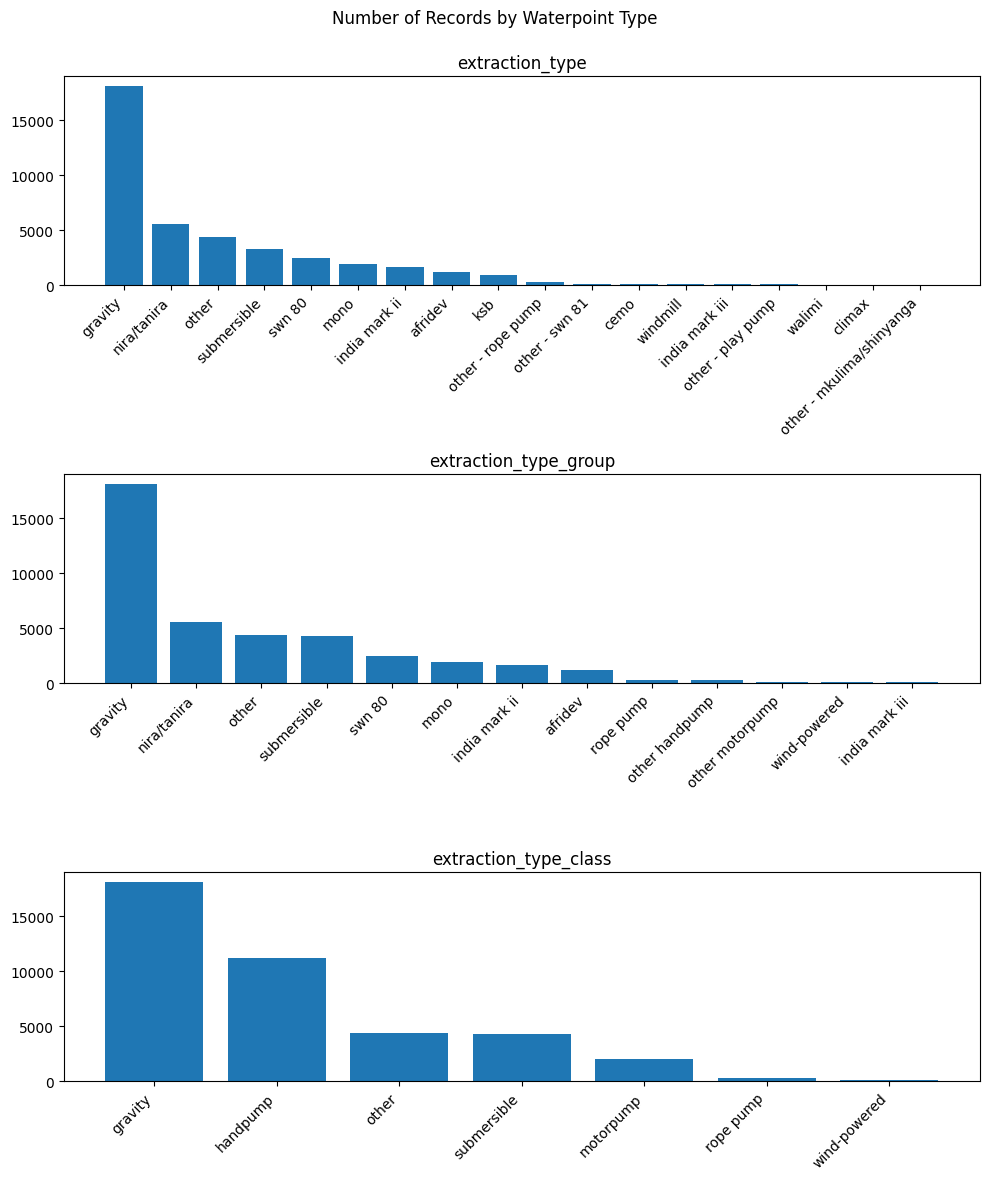

In [119]:
# prepare data
extraction_type = training_set.extraction_type.value_counts()
extraction_type_group = training_set.extraction_type_group.value_counts()
extraction_type_class = training_set.extraction_type_class.value_counts()

# plot data
fig, axes = plt.subplots(nrows=3, figsize=(10, 12))
axes[0].bar(extraction_type.index, extraction_type.values)
axes[0].set_title('extraction_type')
axes[1].bar(extraction_type_group.index, extraction_type_group.values)
axes[1].set_title('extraction_type_group')
axes[2].bar(extraction_type_class.index, extraction_type_class.values)
axes[2].set_title('extraction_type_class')
for ax in axes:
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
fig.suptitle('Number of Records by Waterpoint Type\n')
fig.tight_layout();


This is the first set of duplicate features where it is unclear which is the best to keep. We should only keep one, since they are duplicates.

'extraction_type' has the most heavily skewed distribution of values, and the number of records in the tail values may be too low to provide any value. Let's look at the categories with record counts below 5000 for each feature.

In [120]:
print("The values with <5000 record counts in extraction_type are: ")
print(extraction_type.loc[lambda x: x < 5000].to_string())
print()
print("The values with <5000 record counts in extraction_type_group are: ")
print(extraction_type_group.loc[lambda x: x < 5000].to_string())
print()
print("The values with <5000 record counts in extraction_type_class are: ")
print(extraction_type_class.loc[lambda x: x < 5000].to_string())

The values with <5000 record counts in extraction_type are: 
other                        4356
submersible                  3300
swn 80                       2504
mono                         1956
india mark ii                1634
afridev                      1195
ksb                           951
other - rope pump             326
other - swn 81                146
cemo                           69
windmill                       69
india mark iii                 66
other - play pump              60
walimi                         36
climax                         25
other - mkulima/shinyanga       1

The values with <5000 record counts in extraction_type_group are: 
other              4356
submersible        4251
swn 80             2504
mono               1956
india mark ii      1634
afridev            1195
rope pump           326
other handpump      243
other motorpump      94
wind-powered         69
india mark iii       66

The values with <5000 record counts in extraction_type_class a

As predicted, 'extraction_type' has too few values in the tail categories to be useful compared to the other two features.

'extraction_type_group' and 'extraction_type_class' are comparable in their possible contribution to the model. We need to determine which feature better separates the target classes.

Let's take a quick look at the dataframes to see how the classes are divided for each category.

In [121]:
# prepare class division tables
extraction_type_group_df = pd.DataFrame(training_set.extraction_type_group.groupby(
    training_set.status_group
).value_counts()).unstack()
extraction_type_class_df = pd.DataFrame(training_set.extraction_type_class.groupby(
    training_set.status_group
).value_counts()).unstack()

display(extraction_type_group_df)
display(extraction_type_class_df)

extraction_type_group                        \
extraction_type_group                 afridev gravity india mark ii   
status_group                                                          
functional                                799   10843           983   
functional needs repair                    30    1810            54   
non functional                            366    5462           597   

                                                                               \
extraction_type_group   india mark iii  mono nira/tanira other other handpump   
status_group                                                                    
functional                          34   732        3696   724            122   
functional needs repair              1    88         458   146             15   
non functional                      31  1136        1429  3486            106   

                                                                      \
extraction_type_group   other motorpump rope pump submersible swn 80   
status_group                                                           
functional                           44       212        2306   1409   
functional needs repair               7        12         173    146   
non functional                       43       102        1772    949   

                                      
extraction_type_group   wind-powered  
status_group                          
functional                        28  
functional needs repair            6  
non functional                    35

extraction_type_class                           \
extraction_type_class                 gravity handpump motorpump other   
status_group                                                             
functional                              10843     7043       776   724   
functional needs repair                  1810      704        95   146   
non functional                           5462     3478      1179  3486   

                                                            
extraction_type_class   rope pump submersible wind-powered  
status_group                                                
functional                    212        2306           28  
functional needs repair        12         173            6  
non functional                102        1772           35

There are multiple instances in 'extraction_type_group' where there are too few records for each target class for the category to provide value in a multidimensional space. Let's keep 'extraction_type_class'.

##### Management

We have two features for how the pump is managed: 'management' and 'management_group'. Both features are categorical.

In [122]:
columns = [
    'management',
    'management_group',
]

print("The number of unique values in the management features are: ")
print(pd.Series(
    data = [training_set[column].nunique() for column in columns],
    index= columns
).to_string())

The number of unique values in the management features are: 
management          12
management_group     5


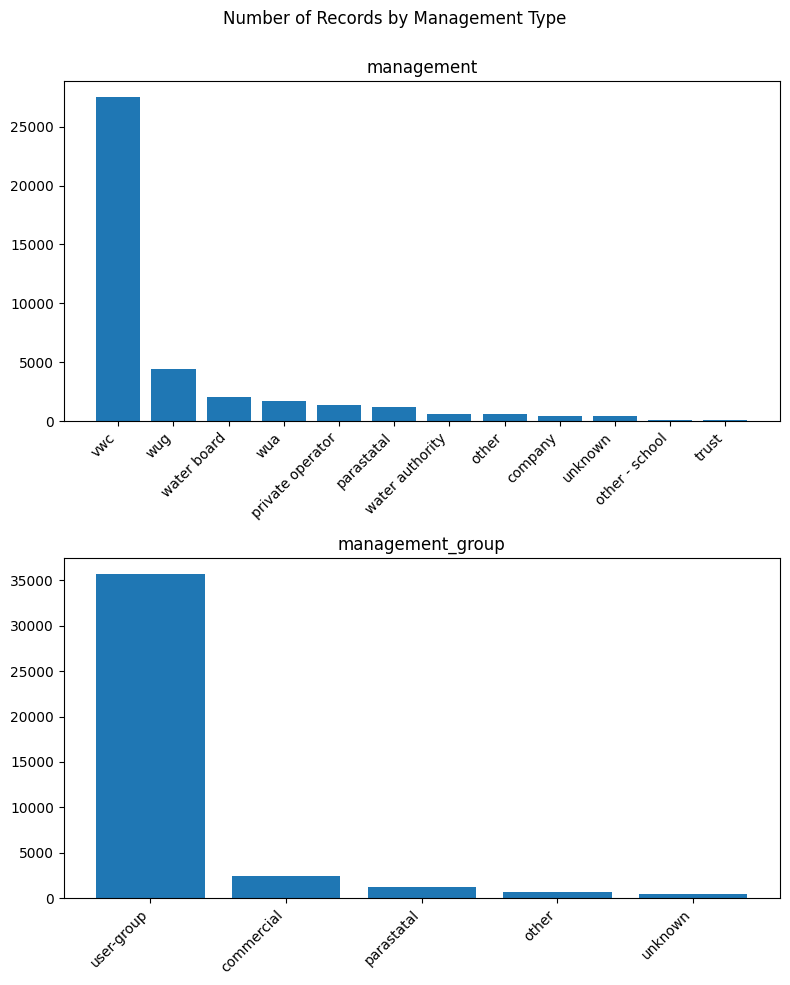

In [123]:
# prepare data
management = training_set.management.value_counts()
management_group = training_set.management_group.value_counts()

# plot data
fig, axes = plt.subplots(nrows=2, figsize=(8, 10))
axes[0].bar(management.index, management.values)
axes[0].set_title('management')
axes[1].bar(management_group.index, management_group.values)
axes[1].set_title('management_group')
for ax in axes:
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
fig.suptitle('Number of Records by Management Type\n')
fig.tight_layout();

Neither feature seems particularly promising, as the vast majority of records in both features fall into a single category. Let's compare the tail values again, and choose the feature with the most records in the least-populated category.

In [124]:
print(f"management's least-populated category has a total of {management[-1]} records.")
print(f"management_group's least-populated category has a total of {management_group[-1]} records.")

management's least-populated category has a total of 50 records.
management_group's least-populated category has a total of 397 records.


We will keep 'management_group'.

##### Payment

We have two features for the water's cost: 'payment' and 'payment_type'. Both features are categorical.

In [125]:
columns = [
    'payment',
    'payment_type',
]

print("The number of unique values in the payment features are: ")
print(pd.Series(
    data = [training_set[column].nunique() for column in columns],
    index= columns
).to_string())

The number of unique values in the payment features are: 
payment         7
payment_type    7


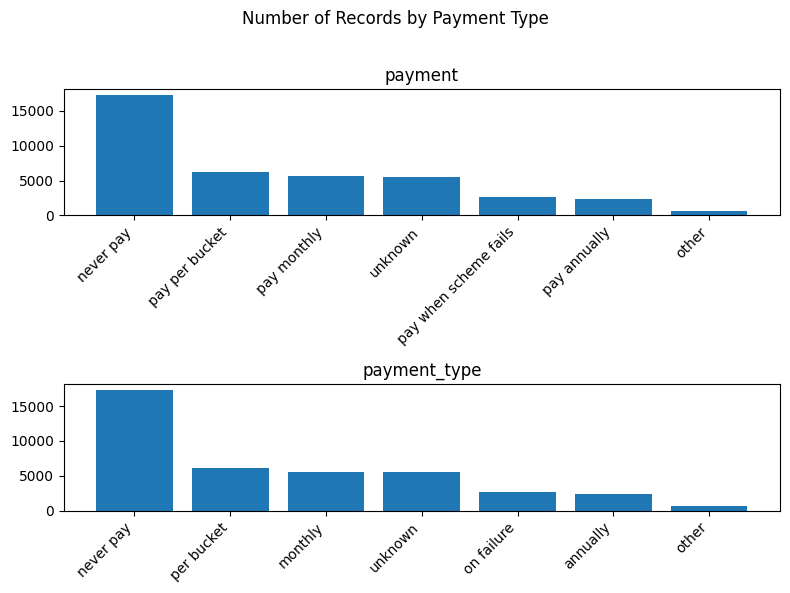

In [126]:
# prepare data
payment = training_set.payment.value_counts()
payment_type = training_set.payment_type.value_counts()

# plot data
fig, axes = plt.subplots(nrows=2, figsize=(8, 6))
axes[0].bar(payment.index, payment.values)
axes[0].set_title('payment')
axes[1].bar(payment_type.index, payment_type.values)
axes[1].set_title('payment_type')
for ax in axes:
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
fig.suptitle('Number of Records by Payment Type\n')
fig.tight_layout();

The features are exactly the same. Let's keep 'payment_type', since it's name is a more accurate description of the feature.

##### Water Quality

We have two features for the water's quality: 'water_quality' and 'quality_group'. Both features are categorical.

In [127]:
columns = [
    'water_quality',
    'quality_group',
]

print("The number of unique values in the Water Quality features are: ")
print(pd.Series(
    data = [training_set[column].nunique() for column in columns],
    index= columns
).to_string())

The number of unique values in the Water Quality features are: 
water_quality    8
quality_group    6


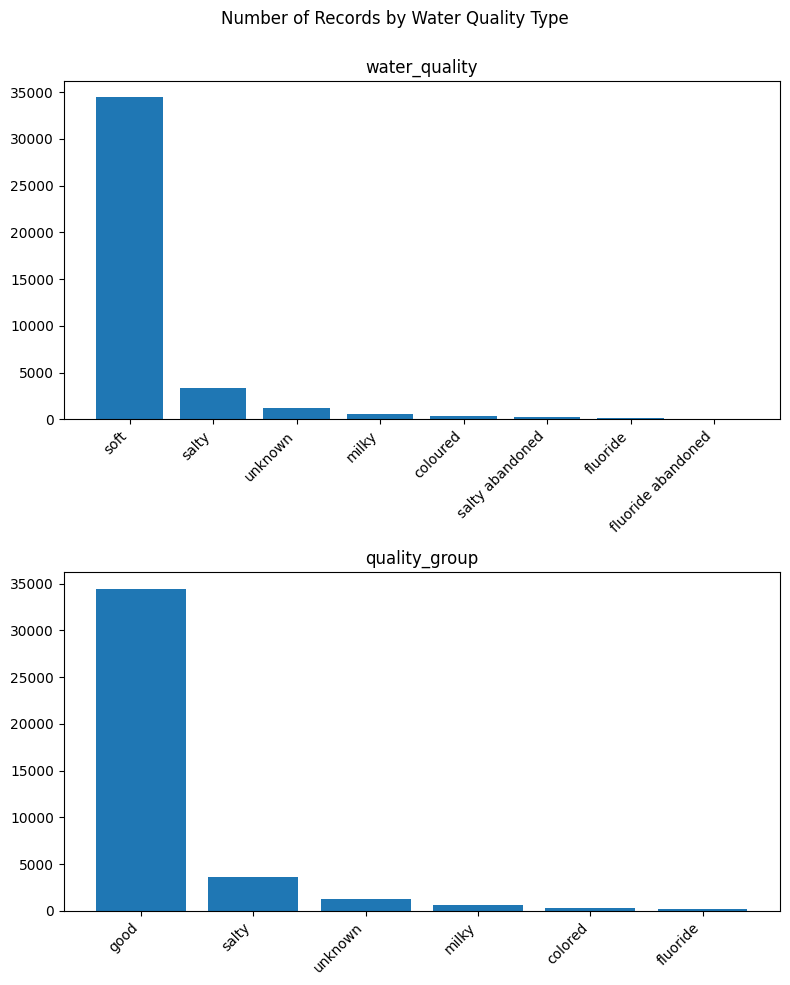

In [128]:
# prepare data
water_quality = training_set.water_quality.value_counts()
quality_group = training_set.quality_group.value_counts()

# plot data
fig, axes = plt.subplots(nrows=2, figsize=(8, 10))
axes[0].bar(water_quality.index, water_quality.values)
axes[0].set_title('water_quality')
axes[1].bar(quality_group.index, quality_group.values)
axes[1].set_title('quality_group')
for ax in axes:
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
fig.suptitle('Number of Records by Water Quality Type\n')
fig.tight_layout();

Again, neither feature seems particularly valuable to our model. The differences in the two features come from the 'abandoned' tag. Let's look at the class separations by category and see if this tag is valuable.

In [129]:
# prepare class division tables
water_quality_df = pd.DataFrame(training_set.water_quality.groupby(
    training_set.status_group
).value_counts()).unstack()
quality_group_df = pd.DataFrame(training_set.quality_group.groupby(
    training_set.status_group
).value_counts()).unstack()

display(water_quality_df)
display(quality_group_df)

water_quality                                     \
water_quality                coloured fluoride fluoride abandoned  milky   
status_group                                                               
functional                      183.0    115.0                5.0  318.0   
functional needs repair          31.0      4.0                NaN   11.0   
non functional                  129.0     23.0                5.0  248.0   

                                                                  
water_quality             salty salty abandoned     soft unknown  
status_group                                                      
functional               1533.0           109.0  19497.0   172.0  
functional needs repair   159.0            47.0   2669.0    25.0  
non functional           1684.0            62.0  12291.0  1072.0

quality_group                                    
quality_group                 colored fluoride   good milky salty unknown
status_group                                                             
functional                        183      120  19497   318  1642     172
functional needs repair            31        4   2669    11   206      25
non functional                    129       28  12291   248  1746    1072

'flouride abandoned' has only non-functional pumps, and the differences in class proportions between 'salty abandoned' and 'salty' are considerable. Let's keep 'water_quality', since the existence of the 'abandoned' tag appears valuable.

##### Water Quantity

We have three features for water quantity: 'amount_tsh', 'quantity', and 'quantity_group'.

'amount_tsh' is a numerical value, where TSH is an acronym for "Total Static Head". It is described on Kaggle as the amount of water available to the waterpoint. We will keep this feature for now and research it later.

The remaining features, 'quantity' and 'quantity_group', are both categorical.

In [130]:
columns = [
    'quantity',
    'quantity_group',
]

print("The number of unique values in the Water Quantity features are: ")
print(pd.Series(
    data = [training_set[column].nunique() for column in columns],
    index= columns
).to_string())

The number of unique values in the Water Quantity features are: 
quantity          5
quantity_group    5


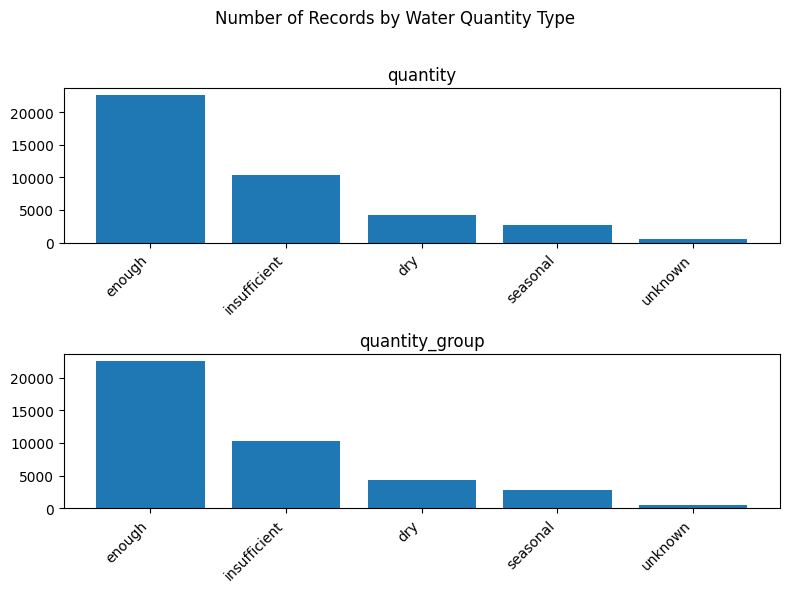

In [131]:
# prepare data
quantity = training_set.quantity.value_counts()
quantity_group = training_set.quantity_group.value_counts()

# plot data
fig, axes = plt.subplots(nrows=2, figsize=(8, 6))
axes[0].bar(quantity.index, quantity.values)
axes[0].set_title('quantity')
axes[1].bar(quantity_group.index, quantity_group.values)
axes[1].set_title('quantity_group')
for ax in axes:
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
fig.suptitle('Number of Records by Water Quantity Type\n')
fig.tight_layout();

These features are the exact same. We will choose 'quantity_group', as it is a more descriptive name than 'quantity', which sounds like a numerical feature.

##### Water Source

We have three features for the water's source: 'source', 'source_type', and 'source_class'. All three features are categorical.

In [132]:
columns = [
    'source',
    'source_type',
    'source_class'
]

print("The number of unique values in the Water Source features are: ")
print(pd.Series(
    data = [training_set[column].nunique() for column in columns],
    index= columns
).to_string())

The number of unique values in the Water Source features are: 
source          10
source_type      7
source_class     3


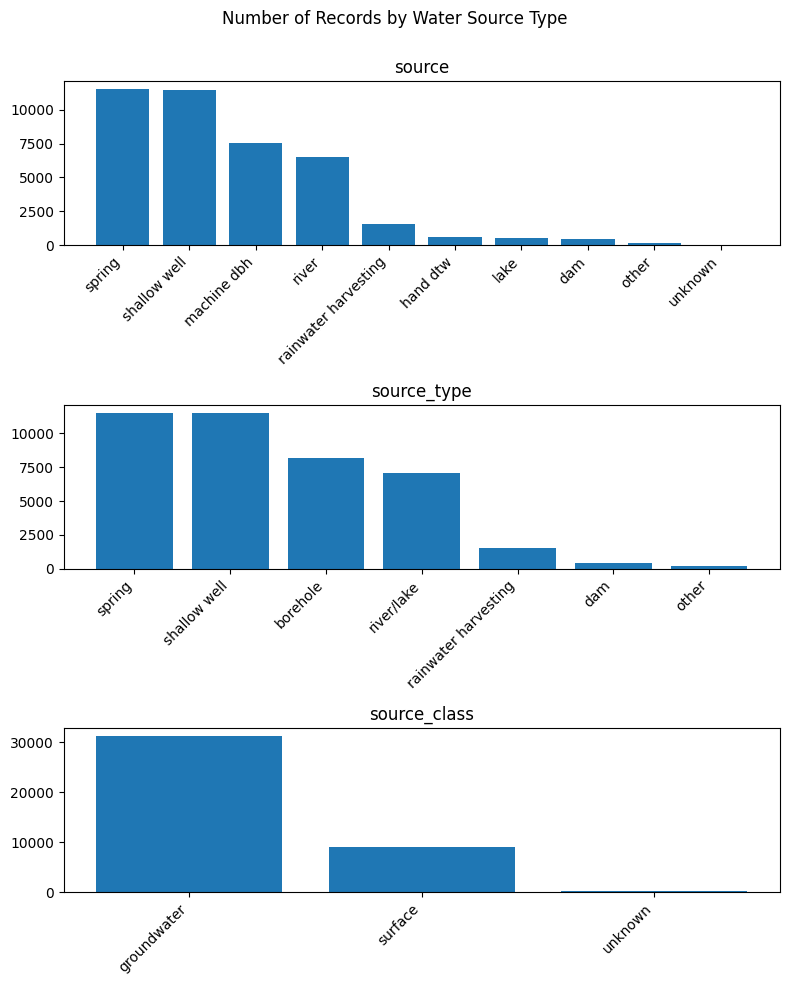

In [133]:
# prepare data
source = training_set.source.value_counts()
source_type = training_set.source_type.value_counts()
source_class = training_set.source_class.value_counts()

# plot data
fig, axes = plt.subplots(nrows=3, figsize=(8, 10))
axes[0].bar(source.index, source.values)
axes[0].set_title('source')
axes[1].bar(source_type.index, source_type.values)
axes[1].set_title('source_type')
axes[2].bar(source_class.index, source_class.values)
axes[2].set_title('source_class')
for ax in axes:
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
fig.suptitle('Number of Records by Water Source Type\n')
fig.tight_layout();

Both 'source' and 'source_type' look like promising features (the number of unique values in 'source_class' is insufficient considering the distribution of records in the other two features), but the 'unknown' category in 'source' may not have enough records.

In [134]:
print(f"The number of records in the 'unknown' class of 'source' is {source[-1]}.")

The number of records in the 'unknown' class of 'source' is 44.


This record count is not low enough for us to disregard the value from the additional categories in source. Let's take a look at the class distributions for eacy category.

In [135]:
# prepare class division tables
source_df = pd.DataFrame(training_set.source.groupby(
    training_set.status_group
).value_counts()).unstack()
source_type = pd.DataFrame(training_set.source_type.groupby(
    training_set.status_group
).value_counts()).unstack()

display(source_df)
display(source_type)

source                                  \
source                     dam hand dtw lake machine dbh other   
status_group                                                     
functional                 164      339  110        3732    84   
functional needs repair     14       11    9         336     1   
non functional             250      250  401        3490    60   

                                                                                
source                  rainwater harvesting river shallow well spring unknown  
status_group                                                                    
functional                               946  3682         5679   7177      19  
functional needs repair                  220   819          679    854       3  
non functional                           385  2035         5125   3496      22

source_type                                  \
source_type                borehole  dam other rainwater harvesting   
status_group                                                          
functional                     4071  164   103                  946   
functional needs repair         347   14     4                  220   
non functional                 3740  250    82                  385   

                                                        
source_type             river/lake shallow well spring  
status_group                                            
functional                    3792         5679   7177  
functional needs repair        828          679    854  
non functional                2436         5125   3496

There are too many instances of single-digit record counts in source. Let's keep 'source_type'.

##### Waterpoint Type

We have two features for waterpoint type: 'waterpoint_type' and 'waterpoint_type_group'. Both features are categorical.

In [136]:
columns = [
    'waterpoint_type',
    'waterpoint_type_group'
]

print("The number of unique values in the Water Source features are: ")
print(pd.Series(
    data = [training_set[column].nunique() for column in columns],
    index= columns
).to_string())

The number of unique values in the Water Source features are: 
waterpoint_type          7
waterpoint_type_group    6


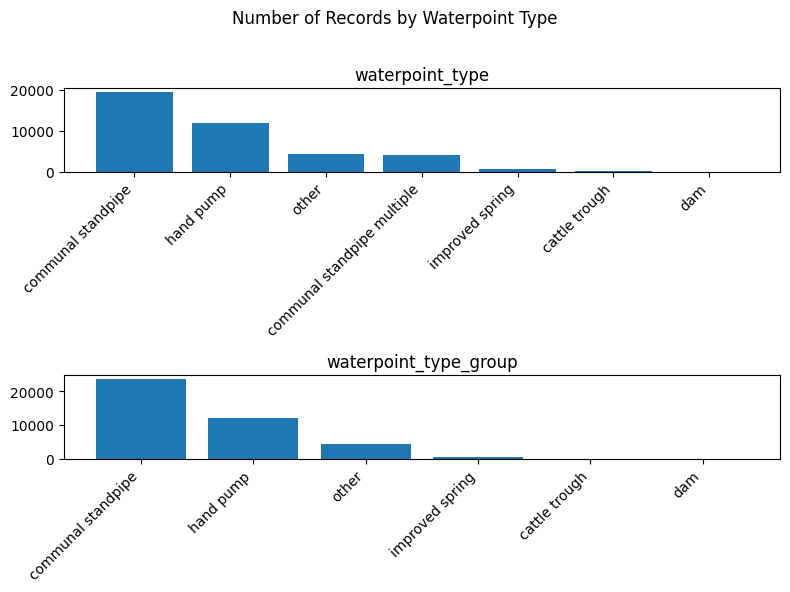

In [137]:
# prepare data
waterpoint_type = training_set.waterpoint_type.value_counts()
waterpoint_type_group = training_set.waterpoint_type_group.value_counts()

# plot data
fig, axes = plt.subplots(nrows=2, figsize=(8, 6))
axes[0].bar(waterpoint_type.index, waterpoint_type.values)
axes[0].set_title('waterpoint_type')
axes[1].bar(waterpoint_type_group.index, waterpoint_type_group.values)
axes[1].set_title('waterpoint_type_group')
for ax in axes:
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
fig.suptitle('Number of Records by Waterpoint Type\n')
fig.tight_layout();

'waterpoint_type_group' has a division of the 'communal standpipe' category with a 'multiple' tag. Having a separation in the most populous category is valuable. We will keep 'waterpoint_type'.

We have addressed all duplicate features.

#### HCCCs (High Cardinality Categorical Columns)

We have marked quite a few features to drop during cleaning. Our next goal is to identify and eliminate any high-cardinality categorical features which may introduce noise into our dataset.

Let's take a tally of the remaining features to keep track of what features we need to explore.

- amount_tsh
- date_recorded
- funder
- gps_height
- installer
- longitude
- latitude
- wpt_name
- basin
- population
- public_meeting
- recorded_by
- scheme_management
- permit
- construction_year
- extraction_type_class
- management_group
- payment_type
- water_quality
- quantity_group
- source_type
- waterpoint_type

We do not need to consider numerical features (unless they are coded categorical columns), date features, or boolean features. These are:

- amount_tsh
- date_recorded
- gps_height
- longitude
- latitude
- population
- public_meeting
- construction_year

We also do not need to consider features which have been examined when eliminating duplicates. These are:

- basin
- scheme_management
- extraction_type_class
- management_group
- payment_type
- water_quality
- quantity_group
- source_type
- waterpoint_type

This leaves us with the following features:

- funder
- installer
- wpt_name
- recorded_by

In [138]:
print(f"'funder' has {training_set.funder.nunique()} unique values.")
print(f"'installer' has {training_set.installer.nunique()} unique values.")
print(f"'wpt_name' has {training_set.wpt_name.nunique()} unique values.")
print(f"'recorded_by' has {training_set.recorded_by.nunique()} unique values.")

'funder' has 1573 unique values.
'installer' has 1766 unique values.
'wpt_name' has 26611 unique values.
'recorded_by' has 1 unique values.


'wpt_name' is a clear HCCC, so it can be dropped.

'recorded_by' only has one unique value, and therefore provides no target class separation, so it can be dropped as well.

'funder' and 'installer' are HCCCs, but we should view how the highest-proportion categories are distributed before disregarding them.

In [139]:
print("The five categories in 'funder' with the largest proportion of records are: ")
print(training_set.funder.value_counts(normalize=True)[:5].to_string())
print()
print("The five categories in 'installer' with the largest proportion of records are: ")
print(training_set.installer.value_counts(normalize=True)[:5].to_string())

The five categories in 'funder' with the largest proportion of records are: 
Government Of Tanzania    0.162615
Danida                    0.055497
Hesawa                    0.040047
Rwssp                     0.025547
World Bank                0.024123

The five categories in 'installer' with the largest proportion of records are: 
DWE           0.312076
Government    0.031569
RWE           0.021626
Commu         0.019200
DANIDA        0.018646


The categories are less mismatched than expected. There is an opportunity to consolidate the low-record-count categories in each feature under a common 'other' category. Let's explore how many categories there are in each feature with record counts less than 1000, 100, and 10.

In [140]:
funder_under_1000 = training_set.funder.value_counts().loc[
    training_set.funder.value_counts() < 1000
].count()
funder_under_100 = training_set.funder.value_counts().loc[
    training_set.funder.value_counts() < 100
].count()
funder_under_10 = training_set.funder.value_counts().loc[
    training_set.funder.value_counts() < 10
].count()
installer_under_1000 = training_set.installer.value_counts().loc[
    training_set.installer.value_counts() < 1000
].count()
installer_under_100 = training_set.installer.value_counts().loc[
    training_set.installer.value_counts() < 100
].count()
installer_under_10 = training_set.installer.value_counts().loc[
    training_set.installer.value_counts() < 10
].count()

print(f"'funder' has {funder_under_1000} unique categories with record counts less than 1000.")
print(f"'funder' has {funder_under_100} unique categories with record counts less than 100.")
print(f"'funder' has {funder_under_10} unique categories with record counts less than 10.")
print()
print(f"'installer' has {installer_under_1000} unique categories with record counts less than 1000.")
print(f"'installer' has {installer_under_100} unique categories with record counts less than 100.")
print(f"'installer' has {installer_under_10} unique categories with record counts less than 10.")

'funder' has 1570 unique categories with record counts less than 1000.
'funder' has 1513 unique categories with record counts less than 100.
'funder' has 1230 unique categories with record counts less than 10.

'installer' has 1764 unique categories with record counts less than 1000.
'installer' has 1709 unique categories with record counts less than 100.
'installer' has 1429 unique categories with record counts less than 10.


This is an interesting result. We can likely consolidate the low-record categories in these features into a single category. We will move forward without them to develop the MVP and save this idea for a second iteration of the model building process.

For now, we will drop these features.

#### Explicit Nulls

After the elimination of HCCCs, the remaining features are:
- amount_tsh
- date_recorded
- gps_height
- longitude
- latitude
- basin
- population
- public_meeting
- scheme_management
- permit
- construction_year
- extraction_type_class
- management_group
- payment_type
- water_quality
- quantity_group
- source_type
- waterpoint_type

Let's take a look at the explicit nulls in our remaining features.

In [141]:
surviving_features = [
    'amount_tsh',
    'date_recorded',
    'gps_height',
    'longitude',
    'latitude',
    'basin',
    'population',
    'public_meeting',
    'scheme_management',
    'permit',
    'construction_year',
    'extraction_type_class',
    'management_group',
    'payment_type',
    'water_quality',
    'quantity_group',
    'source_type',
    'waterpoint_type'
]

print("For each remaining feature, the count of explicit nulls is: ")
print(training_set[surviving_features].isnull().sum().to_string())

For each remaining feature, the count of explicit nulls is: 
amount_tsh                  0
date_recorded               0
gps_height                  0
longitude                   0
latitude                    0
basin                       0
population                  0
public_meeting           2289
scheme_management        2677
permit                   2085
construction_year           0
extraction_type_class       0
management_group            0
payment_type                0
water_quality               0
quantity_group              0
source_type                 0
waterpoint_type             0


Only three of our features have explicit nulls, and for each of those features, the proportion of null values is about 5%. It will be acceptable to impute these values as necessary.

#### Feature Research & Implicit Nulls

Now that we're working with a manageable number of features, let's explore each of them more to better understand them and determine possible implicit null values.

##### amount_tsh

As stated before, amount_tsh in the description given by Kaggle is "amount of water available to the waterpoint".

Some research into total static head yields a more complicated description. Per [this post](https://inspectapedia.com/water/Well_Static_Head_Definition.php), "the static head in a well is is not the total amount of water than can be pumped out of the well, it's just where we start." There is also [this pdf](https://www.pumpfundamentals.com/download/book/chapter3.pdf) which describes total static head as "the difference between the discharge static head and the suction static head, or the difference in elevation at the outlet including the pressure head at the outlet, and the elevation at the inlet including the pressure head at the inlet."

The data does not include units, which would be helpful in understanding whether the Kaggle description is sufficient or not. We must assume that the Kaggle description is correct, and that amount_tsh is a measure of how much water is available to the pump, though we still do not know the unit of measurement.

Let's take a quick look at the distribution to see what we can uncover about the data.

<AxesSubplot: >

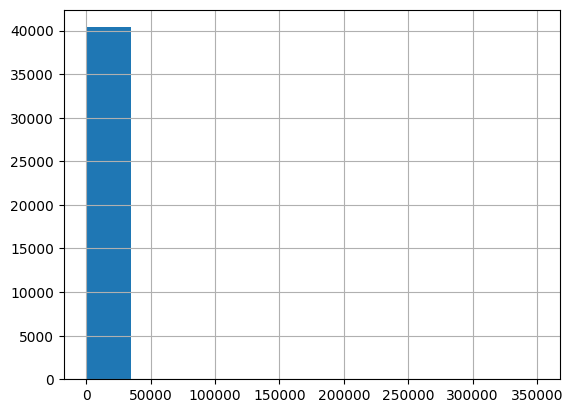

In [142]:
display(training_set.amount_tsh.hist())

We have some clear outliers. Let's see how many there are.

In [143]:
gt_50k = training_set.amount_tsh.loc[training_set.amount_tsh > 50000].count()

print(f"There are {gt_50k} records where 'amount_tsh' is greater than 50,000.")

There are 15 records where 'amount_tsh' is greater than 50,000.


Since there are only 14 outlier values in 'amount_tsh', we will impute null values for these values. We may return to these values and explore them further in a second iteration of this project.

Let's look at a distribution of the remaining values.

<AxesSubplot: >

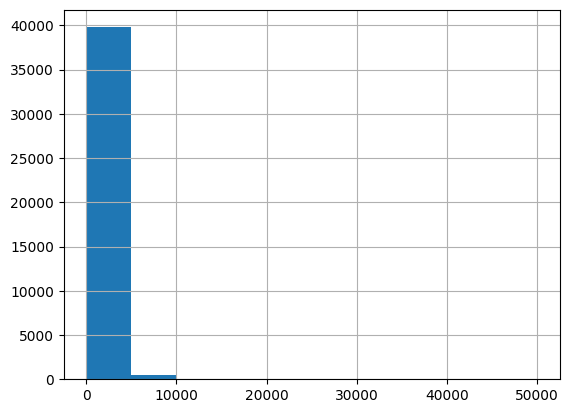

In [144]:
display(training_set.amount_tsh.loc[training_set.amount_tsh <= 50000].hist())

This raises suspicion. How many of these values are zero?

In [145]:
amount_tsh_zero = training_set.amount_tsh.loc[training_set.amount_tsh == 0.0].count()

print(f"There are {amount_tsh_zero} records where 'amount_tsh' is zero.")
print(f"This is {round((amount_tsh_zero/training_set.shape[0])*100, 2)}% of the feature's total values.")

There are 28293 records where 'amount_tsh' is zero.
This is 70.05% of the feature's total values.


More than two-thirds of the values in the dataset for 'amount_tsh' are zero.

This is problematic, since not only is zero a possible value of 'amount_tsh' (where there is no water available to the waterpoint) but it is also a possibility for an implicit null (if the user does not know the value, they may enter zero in its place).

We must consider the trade-off in using this feature, as it can be a valuable indicator of functionality, but we don't want it to add noise to our model. Let's take a look at one more visualization of 'amount_tsh'. Since the values are heavily skewed across such a large range, let's separate the values by our target variable and view them on a log scale.

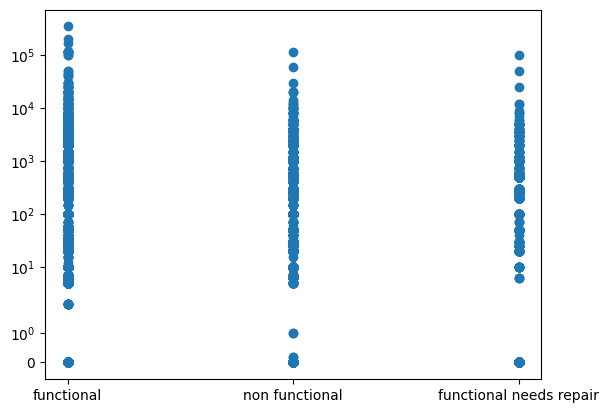

In [146]:
fig, ax = plt.subplots()

ax.scatter(training_set.status_group, training_set.amount_tsh)
ax.set_yscale('symlog')

A much more acceptable distribution of values. In conjunction with other features, our model may find 'amount_tsh' useful when this transformation is applied.

If we intend to use a log10 transformation, we will need to address the zeros in the feature. The easiest solution is to add 1 to all values, since $log_{10}1=0$. 

In the data preparation phase, we will use a numpy.log10(x+1) transformation on the 'amount_tsh' feature.

##### date_recorded and construction_year

'date_recorded' is the date the record was entered. 'construction_year' is the year the pump was built.


On its own, 'date_recorded' is not a particularly useful feature, but when combined with 'construction_year', this data becomes far more valuable. We can use these features together to determine the pump's age.

A pitfall we may encounter is to disregard 'date_recorded' in favor of simply using 'construction_year' to determine the pump's age. But pump age is an interval of time, and going from the year of construction to the current date would be inconsistent with the data. The 'status_group' of the pump is what was determined on the date it was entered. A pump recorded as functional in 2015 may no longer be functional today. A consistent interval measure of pump age would be the recorded date minus the construction date.

We have another issue in that the time formats of 'date_recorded' and 'construction_year' are incongruent. 'date_recorded' is measured to the day, while 'construction_year' is only the year of construction. We are restricted by 'construction_year'; our pump age can only be as accurate as the year. Additionally, we do not know the exact date of construction during the year, so we may overestimate or underestimate the pump age by a maximum of one year. For example, a pump constructed in November 2000 and recorded in January 2010 would only be 9 years and 3 months old, but we would calcuate the pump as being 10 years old.

There is nothing we can do about this, but it will be important to keep in mind how this may affect our model when we create our 'pump_age' feature.

Let's return to 'date_recorded'. Since this is an object datatype, we can assume that this is in string format, but this is time series data. Let's convert it to a datetime and view the distribution of values.

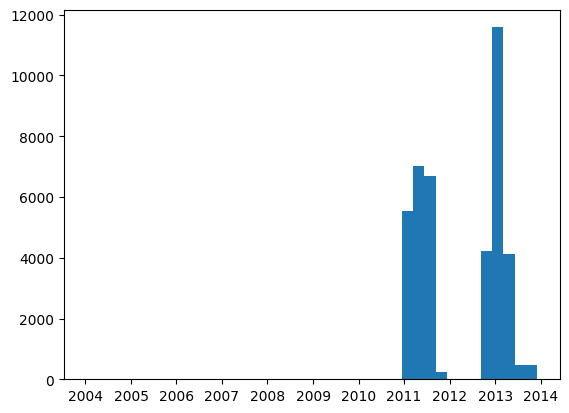

In [147]:
# convert to datetime
date_recorded_dt = pd.to_datetime(training_set.date_recorded, format="%Y-%m-%d")

plt.hist(date_recorded_dt, bins=40);

We didn't get any errors when converting the string values to datetimes, so there probably aren't any hard-coded implicit nulls in the data.

Most of the 'date_recorded' values are between 2011 and 2014. Let's see how many records there are before that.

In [148]:
date_recorded_pre2011 = date_recorded_dt.loc[date_recorded_dt < pd.to_datetime("2011-01-01")]

print(f"There are {date_recorded_pre2011.count()} records in 'date_recorded' with dates before 2011.")
print("Those dates are: ")
print(date_recorded_pre2011.to_string())

There are 17 records in 'date_recorded' with dates before 2011.
Those dates are: 
2367    2004-04-01
2977    2004-12-01
4349    2004-12-01
7867    2004-03-06
7944    2004-03-01
8310    2004-12-01
8825    2004-12-01
9004    2004-01-07
9664    2004-05-01
11701   2004-05-01
11810   2004-12-01
16874   2004-03-01
22419   2004-03-01
28046   2004-07-01
31758   2004-12-01
33841   2004-12-01
40333   2004-12-01


These are indeed anomalous values compared to the rest of the dataset, but they don't appear to be null values. We can consider them legitimate, especially since we will not be using 'date_recorded' directly in our model.

Let's take a look at 'construction_year'.

<AxesSubplot: >

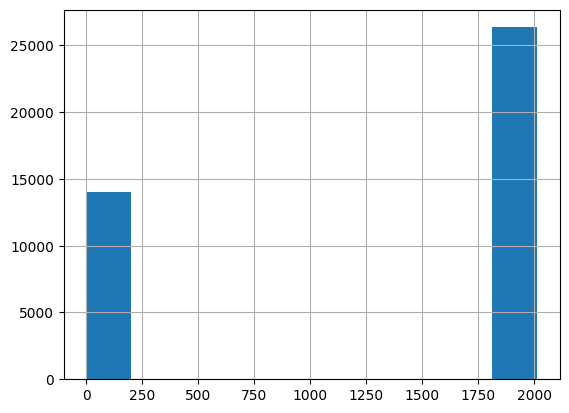

In [149]:
training_set.construction_year.hist()

It appears we have some zero-coded values, since it is highly unlikely that these pumps were built shortly after 0 CE. Let's see how many we have.

In [150]:
construction_year_zero = training_set.construction_year.loc[training_set.construction_year == 0]

print(f"There are {construction_year_zero.count()} zero-coded values in 'constructon_year'.")

There are 14042 zero-coded values in 'constructon_year'.


That's a lot of implicit null values! We'll need to deal with these when we create our pump age feature.

Let's look at the distribution of legitimate values.

<AxesSubplot: >

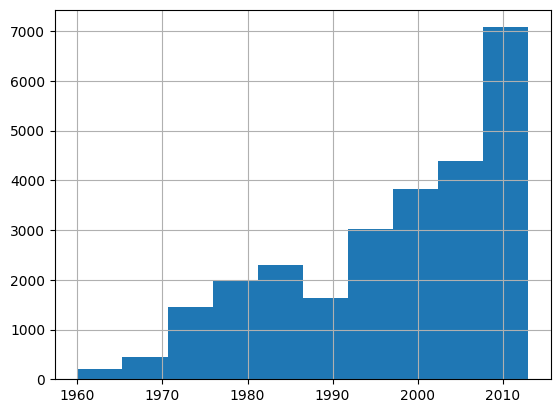

In [151]:
training_set.construction_year.loc[training_set.construction_year > 0].hist()

This is a much more reasonable distribution of values. Again, we'll need to account for the implicit nulls when we're creating our pump age feature, but we have a better idea of the date date we're working with.

##### Location Data

We have four features related to location:
- gps_height
- latitude
- longitude
- basin

Altitude, latitude, and longitude are all valuable features, since different geographical locations are subject to different weather patterns, which can directly affect the well's functionality.

Basin, as stated before when dealing with the duplicate features, is a categorical locational feature identifying the larger basin the well (probably) draws its water from.

We will explore all of these values for implicit nulls and determine their possible contribution to the model.

Let's start with 'gps_height'.

<AxesSubplot: >

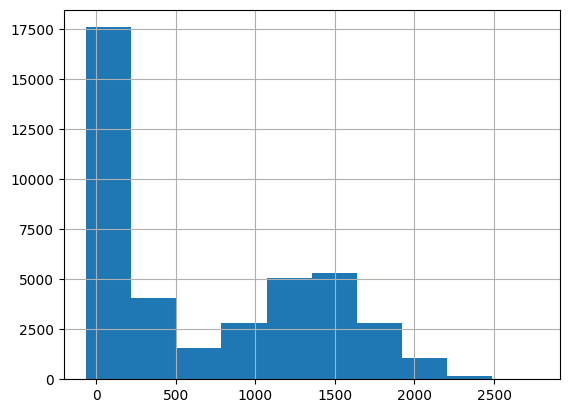

In [152]:
training_set.gps_height.hist()

In [153]:
gps_height_zero = training_set.gps_height.loc[training_set.gps_height == 0]

print(f"There are {gps_height_zero.count()} zero-coded values for 'gps_height'.")

There are 13854 zero-coded values for 'gps_height'.


This is, like 'amount_tsh', an ambiguous value of zero, since it could be an implicit null or a legitimate value (the well is at sea level). A better way to determine which of these values is legitimate would be to compare their locations with a real altitude map of Tanzania. This we would save for a second iteration of this project. For now, we will assume that the zero-coded values are legitimate.

We will compare 'latitude' and 'longitude' in a single plot, as they combine to provide exact geographical location.

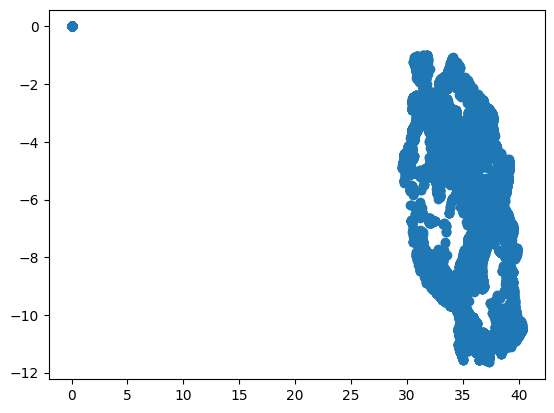

In [154]:
plt.scatter(training_set.longitude, training_set.latitude);

We have (0, 0) coordinates - the infamous "null island". We need to account for these in the data preparation phase. Let's view the scatterplot without these nulls.

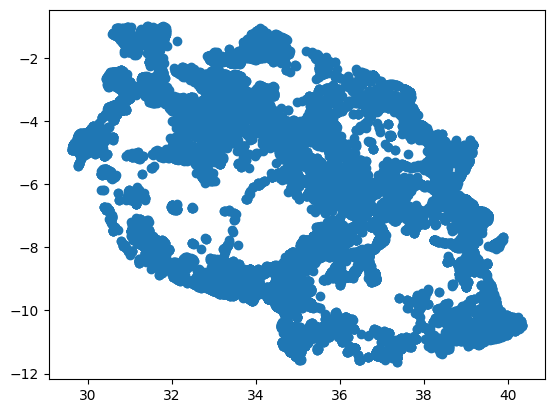

In [155]:
long_lat_not_null = training_set.loc[(training_set.longitude > 1.0) & (training_set.latitude < -0.2)]

plt.scatter(long_lat_not_null.longitude, long_lat_not_null.latitude);

That looks much more like a map of Tanzania.

Let's review the surface level data of 'basin'.

In [156]:
print(f"There are {training_set.basin.nunique()} unique categories in 'basin'.")
print("The proportions of data for each category are: ")
print(training_set.basin.value_counts(normalize=True).to_string())

There are 9 unique categories in 'basin'.
The proportions of data for each category are: 
Lake Victoria              0.172089
Pangani                    0.150995
Rufiji                     0.135076
Internal                   0.131486
Lake Tanganyika            0.107893
Wami / Ruvu                0.101406
Lake Nyasa                 0.084720
Ruvuma / Southern Coast    0.075188
Lake Rukwa                 0.041147


This is a relatively even distribution of value counts, and there are no glaring implicit nulls in the dataset. This seems like an excellent feature to leave as is.

##### Population

'population' is the population around the well. We can assume that this is the population using the well.

Population would affect the well status. More people using the pump would cause additional strain on the pump's parts (and/or no one using the pump may cause the parts to become stiff and rust or fall into disrepair).

<AxesSubplot: >

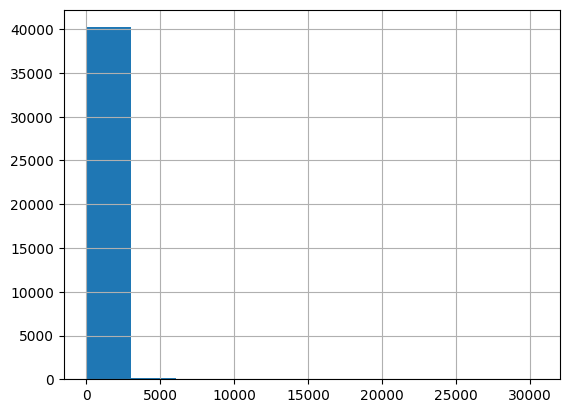

In [157]:
training_set.population.hist()

Another uneven distribution. Let's look at the zero-coded values and the outliers.

In [158]:
pop_gt8k = training_set.population.loc[training_set.population > 5000]
pop_zero = training_set.population.loc[training_set.population == 0]

print(f"There are {pop_gt8k.count()} records with a population greater than 5000.")
print(f"There are {pop_zero.count()} records with a population of zero.")

There are 68 records with a population greater than 5000.
There are 14520 records with a population of zero.


Zero-coded values are possible implicit nulls. It is also possible that the population around the well is indeed zero (no one living in the area to use the well).

We have another feature like 'amount_tsh', an instance of a heavily skewed distribution with outlier values exponentially higher than the majority. Let's apply the log transformation of log10(x+1) to population in the cleaning phase.

##### public_meeting

The description of 'public_meeting' is only that it is a boolean value. We can assume that this feature indicates that some kind of meeting is held, though we do not know who exactly attends this meeting, how regularly a meeting occurs, nor what is discussed or decided during the meeting. We will only keep this value if it provides some separation of the classes.

We must also remain aware that 'public_meeting' has 2284 explicit null values. We do not have a meaningful way of imputing these values, as coding them as true or false would affect the validity of the existing values.

Let's take a look the proportion of records for both 'public_meeting' categories, and the proportion of classes for both categories.

In [159]:
public_meeting_counts = training_set.public_meeting.value_counts(normalize=True)
public_meeting_classes = training_set.status_group.groupby(training_set.public_meeting)

In [160]:
print("The proportions of records for both 'public_meeting' categories are:")
print(public_meeting_counts.to_string())
print()
print("The proportions of classes for both 'public_meeting' categories are: ")
display(public_meeting_classes.value_counts(normalize=True).unstack())

The proportions of records for both 'public_meeting' categories are:
True     0.909403
False    0.090597

The proportions of classes for both 'public_meeting' categories are: 


status_group,functional,functional needs repair,non functional
public_meeting,,,
False,0.432503,0.083720,0.483778
True,0.556348,0.073591,0.370061


There are significant differences in the 'functional' and 'non functional' statuses of the two categories.

These proportions do not include the records with null values. Let's look at the proportions for those.

In [161]:
print("The proportions of records for null values in 'public_meeting' are: ")
print(training_set.loc[
    training_set.public_meeting.isnull()
].status_group.value_counts(normalize=True).to_string())

The proportions of records for null values in 'public_meeting' are: 
functional                 0.507208
non functional             0.446046
functional needs repair    0.046745


These, again, are different enough to keep separate.

In the data preparation phase, let's create an extra category for the null values, so we will have three categories: 'True', 'False', and 'Unknown'.

##### scheme_management

'scheme_management' is who operates the waterpoint. This may be a useful feature, as different operators may perform different levels of regular pump maintenance.

We have 2625 null values in 'scheme_management'. Let's see what distinct categories there are, and what the proportion of records are for each.

In [162]:
print(f"There are {training_set.scheme_management.nunique()} unique categories in 'scheme_management'.")
print("The proportions of records for each category are: ")
print(training_set.scheme_management.value_counts(normalize=True).to_string())

There are 12 unique categories in 'scheme_management'.
The proportions of records for each category are: 
VWC                 0.662389
WUG                 0.093517
Water authority     0.056317
WUA                 0.052552
Water Board         0.049529
Parastatal          0.030757
Private operator    0.019833
Company             0.018348
Other               0.013788
SWC                 0.001723
Trust               0.001220
None                0.000027


Let's look at the exact counts of the categories with the smallest proportions.

In [163]:
training_set.scheme_management.value_counts().tail(6)

Private operator    748
Company             692
Other               520
SWC                  65
Trust                46
None                  1
Name: scheme_management, dtype: int64

The 'SWC' and 'Trust' categories have very few values, but they will be acceptable value counts to use in our model. We may combine these values into a separate category in a second iteration.

The 'None' category only has one value, and provides no value to the model. Despite this being a distinct category (the pump has no operator), we can combine it with our null values into a separate 'unknown' category in the data preparation phase.

##### permit

'permit' is if the waterpoint is permitted.

A value of 'False' in this feature does not necessarily indicate that the pump is illegal; probably, that the installer or operator did not acquire a permit for the pump, whether or not a permit was required. It is also unclear who would issue the permit, though we can assume it would probably be a sector of the Tanzanian government.

We have 2050 explicit null values in this feature.

In [164]:
print("The proportions of records in 'permit' by category are: ")
print(training_set.permit.value_counts(normalize=True).to_string())
print()
print("The proportions of classes in each category are: ")
display(training_set.status_group.groupby(training_set.permit).value_counts(normalize=True).unstack())

The proportions of records in 'permit' by category are: 
True     0.689639
False    0.310361

The proportions of classes in each category are: 


status_group,functional,functional needs repair,non functional
permit,,,
False,0.518715,0.076625,0.404660
True,0.553183,0.069801,0.377016


There is not a significant difference between the class proportions in each category. Let's view the proportions for the null values before we decide to remove the 'permit' feature.

In [165]:
print("The class proportions of the 'permit' null values are: ")
print(training_set.status_group.loc[
    training_set.permit.isnull()
].value_counts(normalize=True).to_string())

The class proportions of the 'permit' null values are: 
functional                 0.552038
non functional             0.356355
functional needs repair    0.091607


These categories are not independent enough to include 'permit' as a feature in our dataset. We will drop this feature in the data preparation phase.

##### Remaining Features

We have viewed the remaining features when eliminating duplicate columns. None of them have any explicit null values. Let's do one last check of the unique categories for each feature to ensure we have no implicit nulls.

In [166]:
remaining_features = [
    'extraction_type_class',
    'management_group',
    'payment_type',
    'water_quality',
'quantity_group',
'source_type',
'waterpoint_type'
]

for feature in remaining_features:
    print(f"There are {training_set[feature].nunique()} unique categories in {feature}.")

There are 7 unique categories in extraction_type_class.
There are 5 unique categories in management_group.
There are 7 unique categories in payment_type.
There are 8 unique categories in water_quality.
There are 5 unique categories in quantity_group.
There are 7 unique categories in source_type.
There are 7 unique categories in waterpoint_type.


In [167]:
print("The unique categories for each feature are: ")
for feature in remaining_features:
    print(f"{feature}: {training_set[feature].unique()}")

The unique categories for each feature are: 
extraction_type_class: ['handpump' 'other' 'gravity' 'motorpump' 'submersible' 'rope pump'
 'wind-powered']
management_group: ['user-group' 'commercial' 'parastatal' 'other' 'unknown']
payment_type: ['never pay' 'monthly' 'on failure' 'other' 'annually' 'per bucket'
 'unknown']
water_quality: ['soft' 'salty' 'unknown' 'coloured' 'fluoride' 'milky' 'salty abandoned'
 'fluoride abandoned']
quantity_group: ['enough' 'insufficient' 'dry' 'seasonal' 'unknown']
source_type: ['shallow well' 'river/lake' 'borehole' 'spring' 'dam'
 'rainwater harvesting' 'other']
waterpoint_type: ['hand pump' 'other' 'communal standpipe' 'communal standpipe multiple'
 'improved spring' 'cattle trough' 'dam']


We have some 'unknown' categories, but these are acceptable.

We have completed our data research. Let's prepare our data for modeling, and create a sanitizing function for testing data and incoming records when our model is deployed.

## Data Preparation

Based on our data understanding, we now have a plan for cleaning, altering, and combining our data.

Since we're assuming that our model will be deployed, and the pump records entered during deployment will have the same format as the records in our training dataset, we will need to consolidate our data preparations for the training set into a function that can be used to consistently reshape incoming records into the format our model recognizes.

### Data Preparation Plan

Let's review our data preparation choices made during the Data Understanding phase.

1. Features to Drop
    - num_private (no description)
    - subvillage (location duplicate)
    - lga (location duplicate)
    - ward (location duplicate)
    - region (location duplicate)
    - region_code (location duplicate)
    - district_code (location duplicate)
    - scheme_name (operator duplicate)
    - extraction_type (extraction type duplicate)
    - extraction_type_group (extraction type duplicate)
    - management (management group duplicate)
    - payment (payment type duplicate)
    - quality_group (quality type duplicate)
    - quantity (quantity type duplicate)
    - source (source type duplicate)
    - source_class (source type duplicate)
    - waterpoint_type_group (waterpoint type duplicate)
    - funder (HCCC)
    - installer (HCCC)
    - wpt_name (HCCC)
    - recorded_by (single-value)
    - permit (categories lack significant class separation)
2. Feature Engineering
    - pump_age (from date_recorded and construction_year)
        - drop date_recorded and construction_year after creating pump_age
3. Data Transformations
    - amount_tsh (log10(x+1))
    - population (log10(x+1))
4. Impute Nulls
    - public_meeting (additional category 'unknown')
    - scheme_management ('None' and nulls into 'unknown')

Our features remaining after these preparations are:
- amount_tsh (transformed)
- gps_height
- longitude
- latitude
- basin
- population
- public_meeting
- scheme_management
- extraction_type_class
- management_group
- payment_type
- water_quality
- quantity_group
- source_type
- waterpoint_type
- pump_age

We need to be prepared for the possibility that incoming records during deployment will have missing values. Let's determine our imputation choices for each remaining feature.

- amount_tsh: 0.0
    - The mode, and our implicit null value
- gps_height: 0.0
    - The mode, and our implicit null value
- longitude & latitude: 0.0
    - Despite (0, 0) being an incorrect coding for a real location, we will keep these "null island" values in our training set so our model will recognize that these values are illegitimate for use in determining well functionality.
- basin: 'Lake Victoria'
    - Most common category
- population: 0.0
    - The mode, and our implicit null value
- public meeting: "unknown"
    - Our created null category
- scheme_management: "unknown"
    - Our created null category
- extraction_type_class: "gravity"
    - Most common category
- management_group: "user-group"
    - Most common category
- payment_type: "never pay"
    - Most common category
- water_quality: "soft"
    - Most common category
- quantity_group: "enough"
    - Most common category
- source_type: "spring"
    - Most common category
- waterpoint_type: "communal standpipe"
    - Most common category
- pump_age: -100
    - A pump could be recorded in the same year it was built. For this reason, we will create an implicit null value for pump age far from any valid pump ages so our model will understand that these values are inaccurate, and will evaluate them differently than valid values.

Let's go through each section of the plan, and combine our code into a reusable function at the end.

### Feature Matrix and Target Vector

Any incoming data will not have the 'status_group' column, since this is what we are trying to predict. Let's separate our features from our target.

We will also perform this operation for our testing set here.

In [168]:
# separate feature matrix and target vector for our training and testing sets
X_train = training_set.drop(columns=['status_group'])
y_train = training_set.status_group

X_test = testing_set.drop(columns=['status_group'])
y_test = testing_set.status_group

# validate
print(f"The pre-split training set has {training_set.shape[0]} rows and {training_set.shape[1]} columns.")
print(f"The pre-split testing set has {testing_set.shape[0]} rows and {testing_set.shape[1]} columns.")
print()
print(f"X_train has {X_train.shape[0]} rows and {X_train.shape[1]} columns.")
print(f"y_train is a series with {y_train.shape[0]} rows.")
print()
print(f"X_test has {X_test.shape[0]} rows and {X_test.shape[1]} columns.")
print(f"y_test is a series with {y_test.shape[0]} rows.")

The pre-split training set has 40392 rows and 40 columns.
The pre-split testing set has 7128 rows and 40 columns.

X_train has 40392 rows and 39 columns.
y_train is a series with 40392 rows.

X_test has 7128 rows and 39 columns.
y_test is a series with 7128 rows.


### Dropping Columns

In [169]:
# drop columns
X_train_clean_ = X_train.drop(columns=[
    'num_private',
    'subvillage',
    'lga',
    'ward',
    'region',
    'region_code',
    'district_code',
    'scheme_name',
    'extraction_type',
    'extraction_type_group',
    'management',
    'payment',
    'quality_group',
    'quantity',
    'source',
    'source_class',
    'waterpoint_type_group',
    'funder',
    'installer',
    'wpt_name',
    'recorded_by',
    'permit'
])

# verify
print("The remaining training set features are: ")
print(X_train_clean_.columns.to_list())

The remaining training set features are: 
['amount_tsh', 'date_recorded', 'gps_height', 'longitude', 'latitude', 'basin', 'population', 'public_meeting', 'scheme_management', 'construction_year', 'extraction_type_class', 'management_group', 'payment_type', 'water_quality', 'quantity_group', 'source_type', 'waterpoint_type']


### Feature Engineering

Let's create our pump age feature.

As stated before in Feature Research, we can only be as accurate as the year when combining our 'date_recorded' and 'construction_year' features.

We need to keep in mind that some of our values, especially in 'construction_year', are inaccurate. We may end up with pumps that are hundreds or thousands of years old, or pumps with negative ages. In these cases, we will impute the values with our specified null of -100.

In [170]:
# extract year from 'date_recorded'
year_recorded = X_train_clean_.date_recorded.apply(lambda x: int(x[:4]))

# calculate pump age
pump_age = year_recorded - X_train_clean_.construction_year

# impute inaccurate values
pump_age = pump_age.apply(lambda x: -100 if (x < 0 or x > 100) else x)

# assign pump_age to feature matrix
X_train_clean_['pump_age'] = pump_age

# drop date_recorded and construction_year features
X_train_clean_ = X_train_clean_.drop(columns=['date_recorded', 'construction_year'])

The remaining training set features are: 
['amount_tsh', 'gps_height', 'longitude', 'latitude', 'basin', 'population', 'public_meeting', 'scheme_management', 'extraction_type_class', 'management_group', 'payment_type', 'water_quality', 'quantity_group', 'source_type', 'waterpoint_type', 'pump_age']

pump_age histogram: 


<AxesSubplot: >

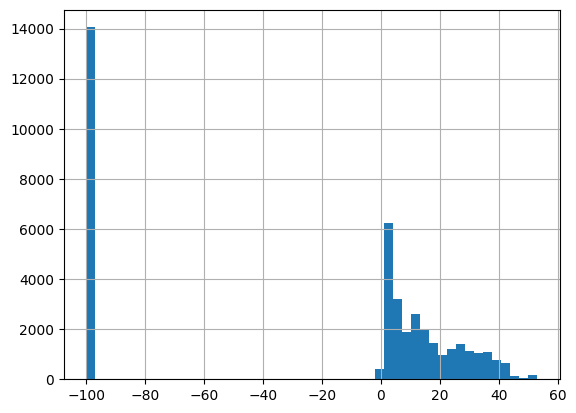

In [171]:
# verify
print("The remaining training set features are: ")
print(X_train_clean_.columns.to_list())
print()
print("pump_age histogram: ")
display(X_train_clean_.pump_age.hist(bins=50))

### Data Transformations

Let's apply our log transformation to amount_tsh and population.

In [172]:
# apply log transformation to amount_tsh
X_train_clean_.amount_tsh = X_train_clean_.amount_tsh.apply(lambda x: np.log10(x+1))

<AxesSubplot: >

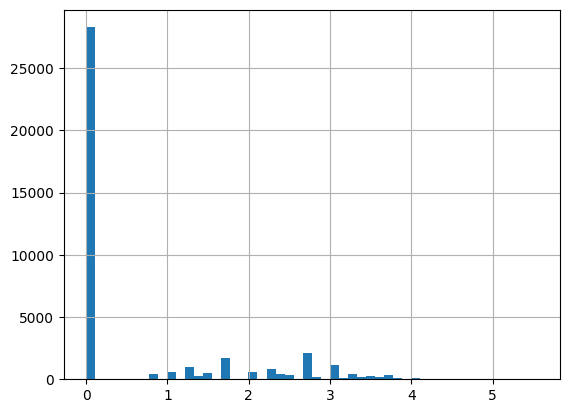

In [173]:
# verify
X_train_clean_.amount_tsh.hist(bins=50)

In [174]:
# apply log transformation to population
X_train_clean_.population = X_train_clean_.population.apply(lambda x: np.log10(x+1))

<AxesSubplot: >

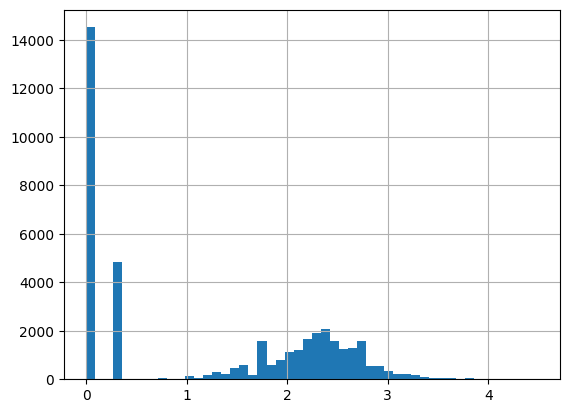

In [175]:
# verify
X_train_clean_.population.hist(bins=50)

### Impute Existing Nulls

We have some existing null values we need to impute.

We are dealing with a boolean series, so let's fill our null values, then convert the remaining values to strings.

In [176]:
# fill nulls in public_meeting
X_train_clean_.public_meeting = X_train_clean_.public_meeting.fillna('unknown')

# convert values to string objects
X_train_clean_.public_meeting = X_train_clean_.public_meeting.apply(lambda x: str(x))

# convert nulls and 'None' value in scheme_management to 'unknown'
X_train_clean_.scheme_management = X_train_clean_.scheme_management.apply(
    lambda x: 'unknown' if (pd.isna(x) or x == 'None') else x
    )

In [177]:
# verify
print("The value counts for each category in 'public meeting' are: ")
print(X_train_clean_.public_meeting.value_counts().to_string())

The value counts for each category in 'public meeting' are: 
True       34651
False       3452
unknown     2289


### Convert Incorrect Datatypes

Let's take a look at our new dataframe, and see if there are any remaining null values or incorrect datatypes.

In [178]:
X_train_clean_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40392 entries, 0 to 40391
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             40392 non-null  float64
 1   gps_height             40392 non-null  int64  
 2   longitude              40392 non-null  float64
 3   latitude               40392 non-null  float64
 4   basin                  40392 non-null  object 
 5   population             40392 non-null  float64
 6   public_meeting         40392 non-null  object 
 7   scheme_management      40392 non-null  object 
 8   extraction_type_class  40392 non-null  object 
 9   management_group       40392 non-null  object 
 10  payment_type           40392 non-null  object 
 11  water_quality          40392 non-null  object 
 12  quantity_group         40392 non-null  object 
 13  source_type            40392 non-null  object 
 14  waterpoint_type        40392 non-null  object 
 15  pu

Our dataframe has been cleaned.

### Custom Imputing Function

Let's define our custom record imputing function from our preparation plan.

In [179]:
def custom_pump_impute(dataframe):

    # define values to impute in nulls
    impute_pairs = {
        'amount_tsh': 1.0,
        'gps_height': 0,
        'basin': 'Lake Victoria',
        'population': 0,
        'public_meeting': 'unknown',
        'extraction_type_class': 'gravity',
        'management_group': 'user-group',
        'payment_type': 'never pay',
        'water_quality': 'soft',
        'quantity_group': 'enough',
        'source_type': 'spring',
        'waterpoint_type': 'communal standpipe',
        'date_recorded': '1850-01-01',
        'construction_year': 0
    }

    # impute null values
    for k, v in impute_pairs.items():
        dataframe[k] = dataframe[k].fillna(v)
    
    # include 'None' in imputed values for scheme_management
    dataframe.scheme_management = dataframe.scheme_management.apply(
        lambda x: 'unknown' if (pd.isna(x) or x == 'None') else x
    )

    return dataframe

### Cleaning Function

Let's bring our cleaning choices together into a single function.

In [180]:
def clean_pump_data(pump_dataframe):
    # drop columns
    pump_dataframe = pump_dataframe.drop(columns=[
    'num_private',
    'subvillage',
    'lga',
    'ward',
    'region',
    'region_code',
    'district_code',
    'scheme_name',
    'extraction_type',
    'extraction_type_group',
    'management',
    'payment',
    'quality_group',
    'quantity',
    'source',
    'source_class',
    'waterpoint_type_group',
    'funder',
    'installer',
    'wpt_name',
    'recorded_by',
    'permit'
    ])

    # apply custom impute function
    pump_dataframe = custom_pump_impute(pump_dataframe)

    # extract year from 'date_recorded'
    year_recorded = pump_dataframe.date_recorded.apply(lambda x: int(x[:4]))
    # calculate pump age
    pump_age = year_recorded - pump_dataframe.construction_year
    # impute inaccurate values
    pump_age = pump_age.apply(lambda x: -100 if (x < 0 or x > 100) else x)
    # assign pump_age to feature matrix
    pump_dataframe['pump_age'] = pump_age
    # drop date_recorded and construction_year features
    pump_dataframe = pump_dataframe.drop(columns=['date_recorded', 'construction_year'])

    # apply log transformations
    pump_dataframe.amount_tsh = pump_dataframe.amount_tsh.apply(lambda x: np.log10(x+1))
    pump_dataframe.population = pump_dataframe.population.apply(lambda x: np.log10(x+1))

    # convert public_meeting boolean values to string objects
    pump_dataframe.public_meeting = pump_dataframe.public_meeting.apply(lambda x: str(x))

    return pump_dataframe


In [181]:
# clean training data
X_train_clean = clean_pump_data(X_train)

In [182]:
# verify cleaning
display(X_train_clean.info())
display(X_train_clean.describe())
for feature in X_train_clean.select_dtypes(include='object').columns:
    print(f"{feature}: {X_train_clean[feature].unique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40392 entries, 0 to 40391
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             40392 non-null  float64
 1   gps_height             40392 non-null  int64  
 2   longitude              40392 non-null  float64
 3   latitude               40392 non-null  float64
 4   basin                  40392 non-null  object 
 5   population             40392 non-null  float64
 6   public_meeting         40392 non-null  object 
 7   scheme_management      40392 non-null  object 
 8   extraction_type_class  40392 non-null  object 
 9   management_group       40392 non-null  object 
 10  payment_type           40392 non-null  object 
 11  water_quality          40392 non-null  object 
 12  quantity_group         40392 non-null  object 
 13  source_type            40392 non-null  object 
 14  waterpoint_type        40392 non-null  object 
 15  pu

None

,amount_tsh,gps_height,longitude,latitude,population,pump_age
count,40392.000000,40392.000000,40392.000000,4.039200e+04,40392.000000,40392.000000
mean,0.686946,667.698628,34.120406,-5.705181e+00,1.223513,-24.765721
std,1.141786,692.756226,6.479407,2.938783e+00,1.155925,55.864667
min,0.000000,-63.000000,0.000000,-1.164944e+01,0.000000,-100.000000
25%,0.000000,0.000000,33.102002,-8.528215e+00,0.000000,-100.000000
50%,0.000000,368.000000,34.915130,-5.018252e+00,1.414973,4.000000
75%,1.322219,1319.000000,37.181087,-3.327902e+00,2.326336,16.000000
max,5.544069,2770.000000,40.345193,-2.000000e-08,4.484314,53.000000


basin: ['Internal' 'Lake Rukwa' 'Rufiji' 'Wami / Ruvu' 'Lake Victoria'
 'Lake Tanganyika' 'Pangani' 'Lake Nyasa' 'Ruvuma / Southern Coast']
public_meeting: ['True' 'False' 'unknown']
scheme_management: ['VWC' 'unknown' 'Water authority' 'Parastatal' 'WUG' 'Water Board' 'SWC'
 'WUA' 'Private operator' 'Company' 'Other' 'Trust']
extraction_type_class: ['handpump' 'other' 'gravity' 'motorpump' 'submersible' 'rope pump'
 'wind-powered']
management_group: ['user-group' 'commercial' 'parastatal' 'other' 'unknown']
payment_type: ['never pay' 'monthly' 'on failure' 'other' 'annually' 'per bucket'
 'unknown']
water_quality: ['soft' 'salty' 'unknown' 'coloured' 'fluoride' 'milky' 'salty abandoned'
 'fluoride abandoned']
quantity_group: ['enough' 'insufficient' 'dry' 'seasonal' 'unknown']
source_type: ['shallow well' 'river/lake' 'borehole' 'spring' 'dam'
 'rainwater harvesting' 'other']
waterpoint_type: ['hand pump' 'other' 'communal standpipe' 'communal standpipe multiple'
 'improved spring' 'c

In [183]:
# verify function cleans test data
X_test_clean = clean_pump_data(X_test)

In [184]:
# verify cleaning
display(X_test_clean.info())
display(X_test_clean.describe())
for feature in X_test_clean.select_dtypes(include='object').columns:
    print(f"{feature}: {X_test_clean[feature].unique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7128 entries, 0 to 7127
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             7128 non-null   float64
 1   gps_height             7128 non-null   int64  
 2   longitude              7128 non-null   float64
 3   latitude               7128 non-null   float64
 4   basin                  7128 non-null   object 
 5   population             7128 non-null   float64
 6   public_meeting         7128 non-null   object 
 7   scheme_management      7128 non-null   object 
 8   extraction_type_class  7128 non-null   object 
 9   management_group       7128 non-null   object 
 10  payment_type           7128 non-null   object 
 11  water_quality          7128 non-null   object 
 12  quantity_group         7128 non-null   object 
 13  source_type            7128 non-null   object 
 14  waterpoint_type        7128 non-null   object 
 15  pump

None

,amount_tsh,gps_height,longitude,latitude,population,pump_age
count,7128.000000,7128.000000,7128.000000,7.128000e+03,7128.000000,7128.000000
mean,0.686311,674.676908,33.926476,-5.703991e+00,1.237575,-24.503507
std,1.154677,694.213325,6.861283,2.970313e+00,1.153410,55.753298
min,0.000000,-48.000000,0.000000,-1.155703e+01,0.000000,-100.000000
25%,0.000000,0.000000,33.012812,-8.567723e+00,0.000000,-100.000000
50%,0.000000,379.000000,34.885676,-5.013517e+00,1.491362,4.000000
75%,1.322219,1324.000000,37.171869,-3.318963e+00,2.344392,16.000000
max,5.397942,2614.000000,40.322625,-2.000000e-08,4.000043,53.000000


basin: ['Pangani' 'Rufiji' 'Internal' 'Lake Victoria' 'Wami / Ruvu'
 'Ruvuma / Southern Coast' 'Lake Nyasa' 'Lake Rukwa' 'Lake Tanganyika']
public_meeting: ['True' 'False' 'unknown']
scheme_management: ['VWC' 'unknown' 'WUA' 'WUG' 'Private operator' 'Parastatal' 'Water Board'
 'Water authority' 'Other' 'Company' 'Trust' 'SWC']
extraction_type_class: ['handpump' 'submersible' 'gravity' 'motorpump' 'other' 'wind-powered'
 'rope pump']
management_group: ['user-group' 'commercial' 'parastatal' 'other' 'unknown']
payment_type: ['never pay' 'unknown' 'per bucket' 'annually' 'monthly' 'on failure'
 'other']
water_quality: ['soft' 'salty' 'milky' 'fluoride' 'salty abandoned' 'coloured' 'unknown'
 'fluoride abandoned']
quantity_group: ['seasonal' 'insufficient' 'enough' 'dry' 'unknown']
source_type: ['shallow well' 'borehole' 'river/lake' 'spring' 'other'
 'rainwater harvesting' 'dam']
waterpoint_type: ['hand pump' 'communal standpipe' 'communal standpipe multiple'
 'improved spring' 'other' 'c

Excellent. Our data is cleaned and prepared for modeling.

## Modeling

Now that our data is cleaned and prepared, let's build some models and test them for prediction accuracy.

### Modeling Plan

Let's outline a plan for this phase.

1. Review and prepare accuracy metric
2. Prepare modeling baseline
3. Determine best models to test given metric and data
4. Determine and generate test design
5. Build, tune, and compare models

### Review and Prepare Accuracy Metric

In the Business Understanding section, we decided that our accuracy metric will be One-vs-Rest multiclass ROC AUC. This will give us the best understanding of the sensitivity and specificity of the model for each of our classes for different thresholds, and additionally, we could average the scores between the three curves to determine an overall accuracy.

For evaluation of the model, we must consolidate the results of the three ROC AUC curves for each class into a single number. We will take the average of the three scores, weighted inversely by the proportion of the class in the overall dataset.

It is important to note that we are losing information *and* control over the accuracy metric when we consolidate the scores like this. By using our chosen metric to compare the accuracy of models against each other, we lose control over which class curves we would like to prioritize. There is a possibility that we will choose a model that gives a greater overall score because it prioritizes one class while sacrificing another.

For the moment, this is unavoidable; in a future iteration, we may consider the use of a different accuracy metric when comparing our models to combat this potential obstacle, but for the first iteration, it would be inconsistent to use any metric other than the one we have already defined: the weighted average of the One-vs-Rest ROC AUC curves.

Let's create a function that will plot our chosen metric so that our client will better be able to visualize the classification tradeoff in our chosen model.

In [185]:
def plot_roc_auc(y_true, y_prob, classes):
    # transform target vector
    lb = LabelBinarizer()
    lb.fit(y_true)
    y_true = lb.transform(y_true)

    # initialize rate containers
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # generate curves and AUC values for each class
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # plot curves
    plt.figure(figsize=(8, 6))
    colors = ['blue', 'red', 'green']
    for i, color in zip(range(len(classes)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (AUC = {1:0.2f})'
                 ''.format(classes[i], roc_auc[i]))
    # styling
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 0.8])
    plt.ylim([0.2, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('One-vs-Rest ROC AUC')
    plt.legend(loc="lower right")
    plt.show()


While this visualization will be useful to the client for manipulating the threshold for each class, it does not provide explicit classifications, which is our goal.

For predictions, we will generate the probabilities for each class, and choose the maximum value.

### Modeling Baseline

Before we begin modeling, we should define a baseline score that our models should always be able to beat.

A good baseline for a classification is to make any prediction be the majority class. In our case, that means that all of our predictions would be 'functional.'

In [187]:
# accuracy of model when all pumps are predicted 'functional'
all_functional_accuracy = y_test.value_counts(normalize=True).loc['functional']
print(
    ' '.join(
        f"""A model that classifies all pumps as 'functional' would be
 {round(all_functional_accuracy*100, 2)}%
 accurate when predicting our test set.""".splitlines()
    )
)

A model that classifies all pumps as 'functional' would be  54.29%  accurate when predicting our test set.


A more realistic accuracy score, in the context of pump maintenance, would be to assume that all wells are non-functional. This would result in repair teams being sent to all pumps, but at least all pumps would be functional after the repairs, and the loss would be in wasted resources rather than human lives.

In [188]:
# accuracy of model when all pumps are predicted 'non functional'
all_non_functional_accuracy = y_test.value_counts(normalize=True).loc['non functional']
print(
    ''.join(
        f"""A model that classifies all pumps as 'non functional' would be
 {round(all_non_functional_accuracy*100, 2)}%
 accurate when predicting our test set.""".splitlines()
    )
)

A model that classifies all pumps as 'non functional' would be 38.41% accurate when predicting our test set.


We should note that this accuracy metric is inconsistent with our multiclass ROC AUC score. A simple accuracy metric only measures one threshold across all classes. In the context of our scorer, both the individual and average AUC scores would be 50% accurate because we have a constant prediction; the true positive rate and the false positive rate would not change at different thresholds.

For the purpose of developing a good baseline, we will keep the highest accuracy score we can achieve when using a static prediction, even though using a baseline of 'non functional' would be more suitable in a client context, and the metric of the highest score may be inconsistent with our chosen multiclass ROC AUC score.

We want our model to perform with an overall accuracy higher than 54.29%.

### Determine Best Models to Test

Now that we have our baseline, let's determine what kinds of models would be best suited for our data and desired outcome.

Since our model is a multiclass classification predictor, we have two main options:

1. Rule-based classification (decision tree algorithms)
2. Multidimensional separation of classes (SVM, Nearest Neighbors)

One of the major hurdles we must overcome with our data is that we have many categorical features. In a lot of machine learning models, transforming a categorical feature into a computer-readable format requires a numerical transformation. This can cause our model to make inaccurate connections, since a numerical transformation would imply that the categories are ordered even when they are unrelated (or cannot be ordered in a meaningful way).

Rule-based classification algorithms rely on a series of binary feature threshold decisions to classify a record. This kind of model is especially useful for datasets with multiple categorical features if the model is able to make decisions using *combinations* of categories in a feature, rather than encoding the feature numerically and making a threshold decision.

Multidimensional separation would be an excellent choice too, since it transforms the data into a higher-dimensional space, and makes predictions based on where the prediction record falls within the space. Its drawback is that it would require the categorical features to be ordered because any feature must be plotted on a one-dimensional line.

We should also keep in mind that the client probably wants to know what features are relevant, and how much they impact the model. A model that encodes unordered categorical features numerically may over- or under-estimate the importance of a categorical feature by drawing arbitrary numerical connections between the feature's unordered categories.

The requirement to understand feature importance eliminates most machine learning models that employ multidimensional separation. In SVM, for example, feature importance is only available with a linear kernel because in other kernels, the data is transformed such that it is no longer related to the input space. A Nearest Neighbors model cannot determine feature importance at all, since it only views the distance of the predicted record to nearby points without considering what features contribute to that distance.

We have several options with a rule-based classification. We will try the main three: a single decision tree, a random forest ensemble of decision trees, and a boosted ensemble.

 For the multidimensional models, we would like to try an SVM with a linear kernel, but an actual implementation of this using sklearn is overly complex for the first iteration of this project (technical explanation: to acquire the output of predict_proba from LinearSVC for use in the make_scorer function as our multiclass ROC AUC scorer in cross_val_score, we would need to intercept the data produced by LinearSVC.decision_function and apply softmax before passing to the make_scorer function used as the cross_val_score scorer. In short, we would need to build a custom scorer function compliant with the scorer parameters of cross_val_score). This is unnecessary when we have several rule-based implementations to test, which are more likely to yield a better score than LinearSVC.

Our models to test will be:

1. Single Decision Tree
2. Random Forest (Decision Tree Ensemble)
3. Boosted Ensemble (XGBoost)

### Generate Test Design

Let's decide what test design we'd like to implement.

We have already separated a testing set, but we'd like to save that as a test for development purposes. We'll need to take our training set and separate a validation set for comparing models.

We have two options when it comes to test design:

1. Create a static train and validation set
2. Test using cross-validation

The static sets would be simpler to implement and test against our models, but it would (again) reduce the overall size of our training set. Using cross-validation would take more work and computing power, but we would be able to use the entire dataset for training. Cross-validation would also provide more robust measures of model success, as we would be testing the model on several different training and testing sets. Since we intend to tune our models to measure their success, let's use cross-validation, since many model tuning algorithms use cross-validation to determine optimal hyperparameters.

One pitfall we might encounter when cross-validating our data would be to pass an imputed training set to our model before train-test-splitting for cross-validation. This would cause data leakage, and our scores would be overly-optimistic. However, we don't need to worry about this too much with our data. The only data leakage we should consider is our imputation of the most common category in some categorical variables. However, the common categories we have chosen are generally the vast majority in each feature, and imputing null values with the most common category would introduce less noise into our dataset than to impute the values as some 'unknown' category.

### Build and Compare Models

We've prepped which models to test, and how we will test them. Let's start building.

We don't want to compare base models to each other - that wouldn't be representative of their power. Let's tune each of our chosen models and compare their final scores to decide our final model.

We could use a combination of RandomSearchCV and GridSearchCV to tune our models, but tuning by hand is inefficient. Let's use the computer to help us narrow the optimal combination for each model by tuning using bayesian optimization.

Our models will take different amounts of time and computational power to optimize the hyperparameters, so we will be allowing the simpler models more total evaluations. This does give a scoring edge to the simpler functions, since they will have more opportunities to narrow the optimization, but this will generally be outweighed by the strengths of the more complicated models.

In [189]:
def tune_decision_tree(X, y):
    # define Bayesian Optimization function
    def objective(params):
        # convert integer hyperparameters to integer type
        params['max_depth'] = int(params['max_depth'])
        params['min_samples_split'] = int(params['min_samples_split'])
        params['min_impurity_decrease'] = float(params['min_impurity_decrease'])
        # define classifier with hyperparameters
        clf = DecisionTreeClassifier(
            random_state=42,
            class_weight='balanced',
            **params)
        # encode categorical features
        X_encoded = OrdinalEncoder().fit_transform(X)
        # calculate cross-validation score using roc_auc_ovr_weighted
        score = cross_val_score(
            clf,
            X_encoded, y,
            cv=5,
            scoring='roc_auc_ovr_weighted',
            n_jobs=-1).mean()
        # return negative score to maximize AUC
        return -score

    # define hyperparameters search space
    space = {
        'max_depth': hp.quniform('max_depth', 2, 20, 1),
        'min_samples_split': hp.quniform('min_samples_split', 2, 50, 1),
        'min_impurity_decrease': hp.loguniform('min_impurity_decrease', -5, 0)
    }
    # define optimization algorithm
    tpe_algorithm = tpe.suggest
    # define search trials
    trials = Trials()
    # run optimization
    best_params = fmin(
        objective,
        space,
        algo=tpe_algorithm,
        max_evals=250,
        trials=trials,
        verbose=1)
    # add constant hyperparameters to best_params
    best_params['random_state'] = 42
    best_params['class_weight'] = 'balanced'
    # return best hyperparameters
    return best_params

In [190]:
def tune_random_forest(X, y):
    # define Bayesian Optimization function
    def objective(params):
        # convert integer hyperparameters to integer type
        params['n_estimators'] = int(params['n_estimators'])
        params['max_depth'] = int(params['max_depth'])
        params['min_samples_split'] = int(params['min_samples_split'])
        params['max_samples'] = float(params['max_samples'])
        # define classifier with hyperparameters
        clf = RandomForestClassifier(
            random_state=42,
            class_weight='balanced_subsample',
            n_jobs=-1,
            **params)
        # encode categorical features
        X_encoded = OrdinalEncoder().fit_transform(X)
        # calculate cross-validation score using roc_auc_ovr_weighted
        score = cross_val_score(
            clf,
            X_encoded, y,
            cv=5,
            scoring='roc_auc_ovr_weighted',
            n_jobs=-1).mean()
        # return negative score to maximize AUC
        return -score

    # define hyperparameters search space
    space = {
        'n_estimators': hp.quniform('n_estimators', 50, 500, 10),
        'max_depth': hp.quniform('max_depth', 2, 40, 1),
        'min_samples_split': hp.quniform('min_samples_split', 2, 50, 1),
        'max_samples': hp.quniform('max_samples', 0.1, 1, 0.01)
    }
    # define optimization algorithm
    tpe_algorithm = tpe.suggest
    # define search trials
    trials = Trials()
    # run optimization
    best_params = fmin(
        objective,
        space,
        algo=tpe_algorithm,
        max_evals=125,
        trials=trials,
        verbose=1)
    # add constant hyperparameters to best_params
    best_params['random_state'] = 42
    best_params['class_weight'] = 'balanced_subsample'
    # return best hyperparameters
    return best_params


We need to make some slight changes for our boosted classifier:
- Encode our target variable (XGBClassifier doesn't understand string classes)
- Softmax our objective function (XGBClassifier won't be able to compute our ROC AUC scorer without this)

In [191]:
def tune_XGBClassifier(X, y):
    # define Bayesian Optimization function
    def objective(params):
        # define classifier with hyperparameters
        clf = xgb.XGBClassifier(
            **params,
            objective='multi:softmax',
            num_class=3,
            tree_method='auto',
            random_state=42,
            n_jobs=-1)
        # encode categorical features and target variable
        X_encoded = OrdinalEncoder().fit_transform(X)
        y_encoded = LabelEncoder().fit_transform(y)
        # calculate cross-validation score using roc_auc_ovr_weighted
        cv_results = cross_val_score(
            OneVsRestClassifier(clf),
            X_encoded, y_encoded,
            cv=5,
            n_jobs=-1,
            scoring='roc_auc_ovr_weighted')
        score = np.mean(cv_results)
        # return negative score to maximize AUC
        return {'loss': -score, 'status': STATUS_OK}
    
    # define hyperparameters search space
    space = {
        'max_depth': hp.choice('max_depth', range(1, 15, 1)),
        'learning_rate': hp.loguniform('learning_rate', -5, 0),
        'n_estimators': hp.choice('n_estimators', range(50, 500, 10)),
        'reg_lambda': hp.loguniform('reg_lambda', -5, 0)
    }
    # define search trials
    trials = Trials()
    # run optimization
    best_params = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=75,
                trials=trials)
    # add constant hyperparameters to best_params
    best_params['objective'] = 'multi:softmax',
    best_params['num_class'] = 3,
    best_params['tree_method'] = 'auto',
    best_params['random_state'] = 42,
    best_params['n_jobs'] = -1
    # return best hyperparameters
    return best_params


In [192]:
# TAKES 2m TO RUN

# # get best DecisionTreeClassifier hyperparameters
# dt_params = tune_decision_tree(X_train_clean, y_train)
# print('The best parameters for DecisionTreeClassifier are:')
# for k, v in dt_params.items():
#     print(f"{k}: {v}")

In [193]:
dt_params = {
    'max_depth': 17,
    'min_impurity_decrease': 0.006817050615229018,
    'min_samples_split': 20,
    'random_state': 42,
    'class_weight': 'balanced'
}
print("The best loss for DecisionTreeClassifier is: -0.7317336726425794")
print("The best parameters for DecisionTreeClassifier are:")
for k, v in dt_params.items():
    print(f"{k}: {v}")

The best loss for DecisionTreeClassifier is: -0.7317336726425794
The best parameters for DecisionTreeClassifier are:
max_depth: 17
min_impurity_decrease: 0.006817050615229018
min_samples_split: 20
random_state: 42
class_weight: balanced


In [194]:
# TAKES 9m+ TO RUN

# # get best RandomForestClassifier hyperparameters
# rf_params = tune_random_forest(X_train_clean, y_train)
# print('The best parameters for RandomForestClassifier are:')
# for k, v in rf_params.items():
#     print(f"{k}: {v}")

In [195]:
rf_params = {
    'max_depth': 23,
    'max_samples': 0.5,
    'min_samples_split': 3,
    'n_estimators': 350,
    'random_state': 42,
    'class_weight': 'balanced_subsample'
}
print("The best loss for RandomForestClassifier is: -0.9002107279006613")
print("The best parameters for RandomForestClassifier are:")
for k, v in rf_params.items():
    print(f"{k}: {v}")

The best loss for RandomForestClassifier is: -0.9002107279006613
The best parameters for RandomForestClassifier are:
max_depth: 23
max_samples: 0.5
min_samples_split: 3
n_estimators: 350
random_state: 42
class_weight: balanced_subsample


In [196]:
# TAKES 103m TO RUN

# # get best XGBClassifier hyperparameters
# xgb_params = tune_XGBClassifier(X_train_clean, y_train)
# print('The best parameters for XGBClassifer are:')
# for k, v in xgb_params.items():
#     print(f"{k}: {v}")

In [197]:
xgb_params = {
    'learning_rate': 0.03136343198787678,
    'max_depth': 11,
    'n_estimators': 38,
    'reg_lambda': 0.2496937666996431,
    'objective': 'multi:softmax',
    'num_class': 3,
    'tree_method': 'auto',
    'random_state': 42,
    'n_jobs': -1
}
print("The best loss for XGBClassifier is: -0.8972761723212035")
print("The best parameters for XGBClassifier are:")
for k, v in xgb_params.items():
    print(f"{k}: {v}")

The best loss for XGBClassifier is: -0.8972761723212035
The best parameters for XGBClassifier are:
learning_rate: 0.03136343198787678
max_depth: 11
n_estimators: 38
reg_lambda: 0.2496937666996431
objective: multi:softmax
num_class: 3
tree_method: auto
random_state: 42
n_jobs: -1


Our RandomForestClassifier has the best overall score. Let's implement this model with our optimized hyperparameters.

In [198]:
# initialize model
wp_classifier = RandomForestClassifier(**rf_params)
# initialize and fit encoder
encoder = OrdinalEncoder().fit(X_train_clean)
X_encoded = encoder.transform(X_train_clean)
# fit model
wp_classifier.fit(X_encoded, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=23,
                       max_samples=0.5, min_samples_split=3, n_estimators=350,
                       random_state=42)

Now that our model is complete, let's evaluate its success.

## Evaluation

Let's evaluate our model with our chosen metric and determine if it meets our business requirements.

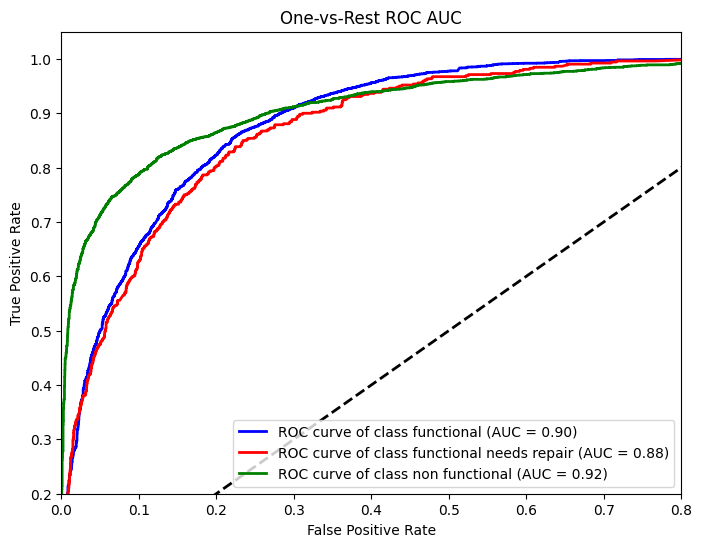

In [199]:
# encode test matrix
X_test_encoded = encoder.transform(X_test_clean)
# generate predictions
wp_preds = wp_classifier.predict_proba(X_test_encoded)
# plot multiclass OvR ROC AUC curves
plot_roc_auc(y_test, wp_preds, ['functional', 'functional needs repair', 'non functional'])

From the curve, we can deduce that our model is most confident in classifying the 'non functional' class, as its change in True Positive Rate climbs the fastest toward 100% while maintaining a low False Positive Rate.

Let's take a look at the general accuracy of the model's predictions. Since we are working with an imbalanced dataset, let's look at how the model performs for each class.

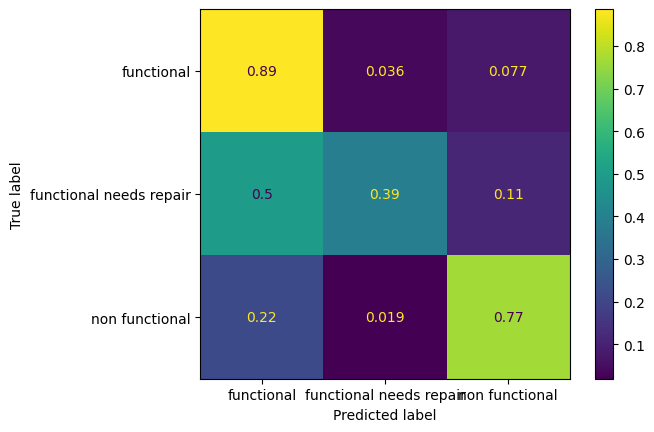

In [225]:
label_map = {
    0 : 'functional',
    1 : 'functional needs repair',
    2 : 'non functional'
}
predictions_int = np.argmax(wp_preds, axis=1)
predictions_str = pd.Series(
    data= [label_map[i] for i in predictions_int],
    name= 'predicted'
)
ConfusionMatrixDisplay.from_predictions(y_test, predictions_str, normalize='true');

Our model is most accurate in classifying 'functional' pumps. It struggles to classify 'functional needs repair' pumps, and it tends to lean towards 'functional' when comparing these pumps. In a second iteration of this project, we might consider tuning 'functional needs repair' toward the 'non functional' class, depending on the client's needs.

Our model correctly classifies around 3/4 of the non-functional pumps. We would prefer to increase the accuracy of this value, since it is of critical importance to know which pumps are broken.

Now that we have our chosen model, and it is able to generate predictions, let's prepare it for deployment.

## Deployment